<a href="https://colab.research.google.com/github/davidjcox333/Man-vs-Machine/blob/RE288/GME_fits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set path to data
from google.colab import drive
drive.mount('/content/gdrive')
%cd './gdrive/My Drive/Matching with RE288/Data'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Matching with RE288/Data


In [23]:
# Packages we'll use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from google.colab import files
import zipfile, io, os
import math

# Fit GME for all pitchers for each season using RE288 as reinforcer. 

In [3]:
# Read in file
data_raw = pd.read_csv("All_MLB_data_for_GME.csv")
data_raw = data_raw.drop(['Unnamed: 0'], axis=1)
data = data_raw.copy()
data.head()

pitch_type   game_date   player_name  ...  runs_inn_end     RE288 RE288_change
0         FF  2016-04-05  Trevor Bauer  ...           0.0  1.969061    -0.016539
1         FF  2016-04-05  Trevor Bauer  ...           0.0  1.952521     0.015919
2         FT  2016-04-05  Trevor Bauer  ...           0.0  1.968441     0.002399
3         FF  2016-04-05  Trevor Bauer  ...           0.0  1.970840    -0.030190
4         FF  2016-04-05  Trevor Bauer  ...           2.0  1.940650     0.012106

[5 rows x 47 columns]

In [4]:
# Create a list of all the unique pitchers in the df
uniq_p = data.player_name.unique()

In [5]:
# Identify which pitches fall in which categories
hrd_strt = ['4-Seam Fastball', '2-Seam Fastball', 'Cutter']
hrd_brkng = ['Slider', 'Sinker', 'Split Finger', 'Screwball', 'Forkball']
sft_strt = ['Changeup', 'Knuckle Ball', 'Eephus']
sft_brkng = ['Curveball', 'Knuckle Curve']

In [19]:
# Strike and out categories 
s_o = ['hit_into_play', 'foul','swinging_strike', 'swinging_strike_blocked', \
       'called_strike','foul_bunt', 'foul_tip', 'missed_bunt','swinging_pitchout', \
       'pitchout_hit_into_play_score','foul_pitchout', 'bunt_foul_tip']

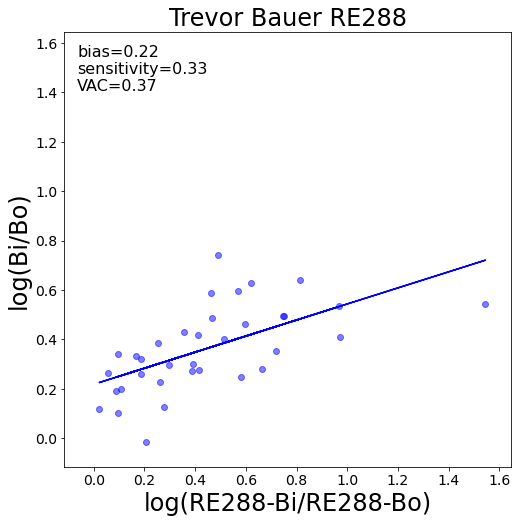

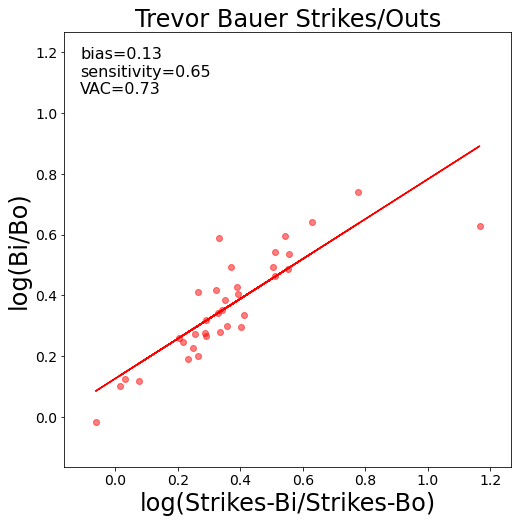

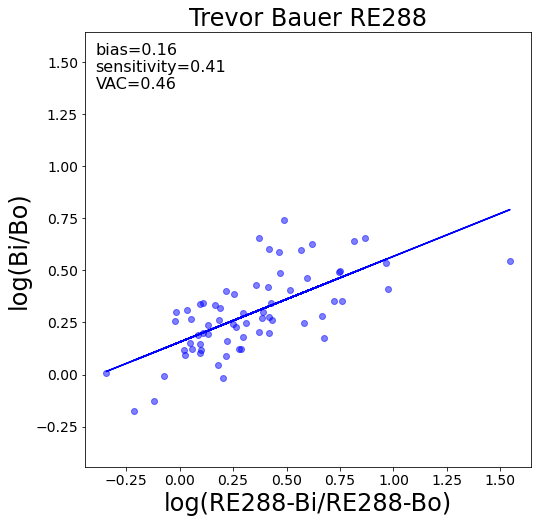

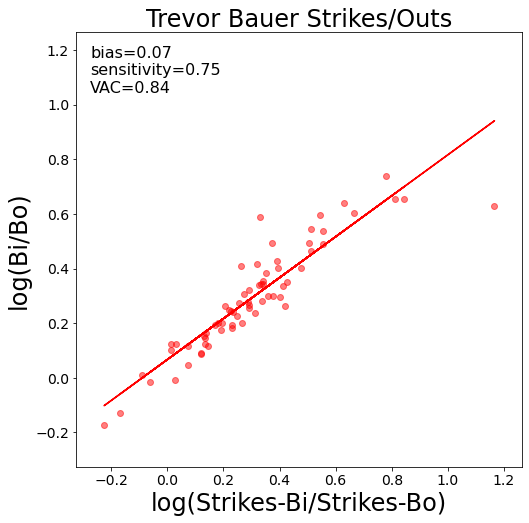

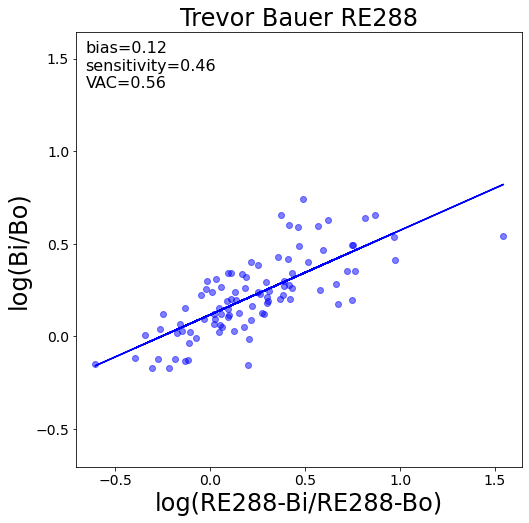

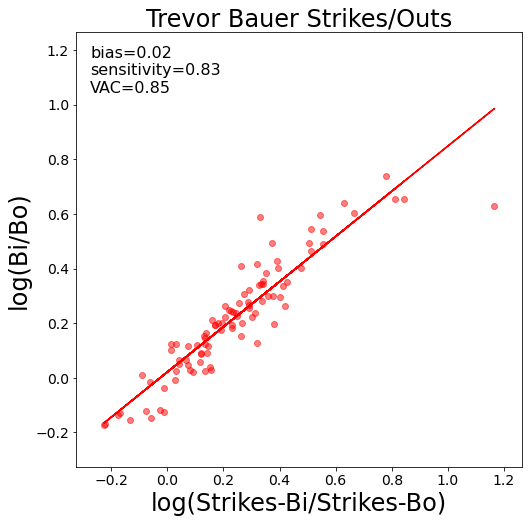

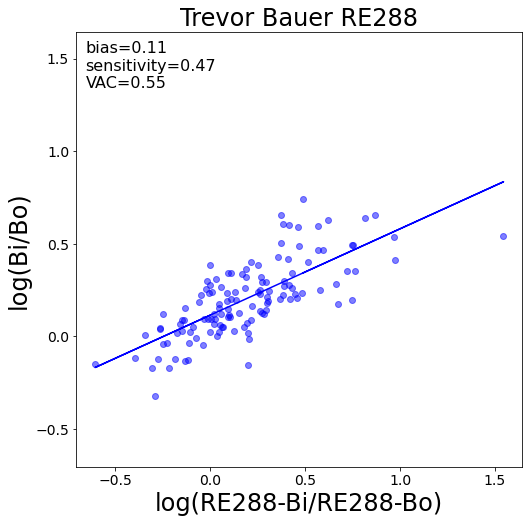

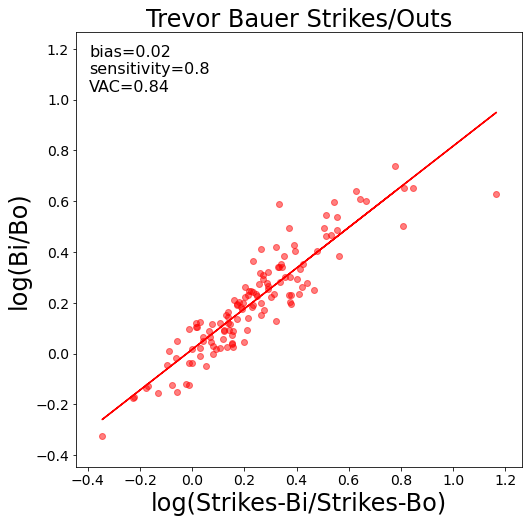

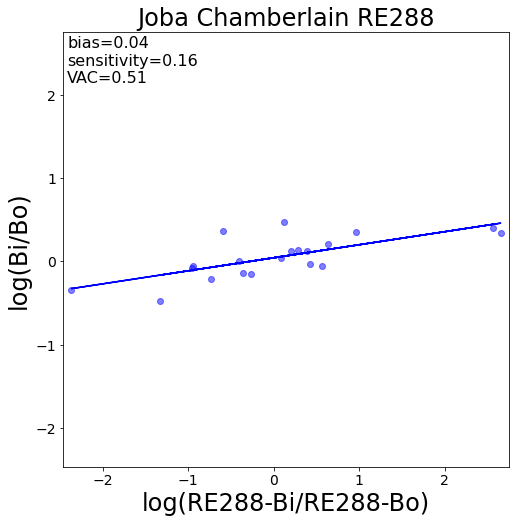

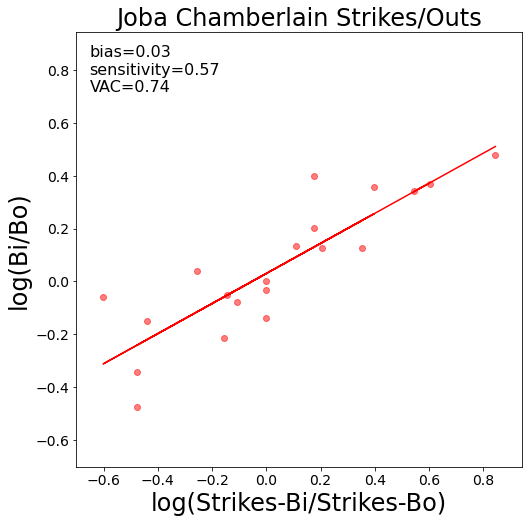

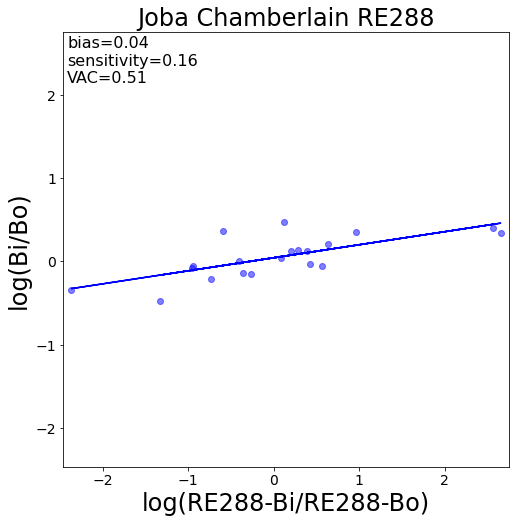

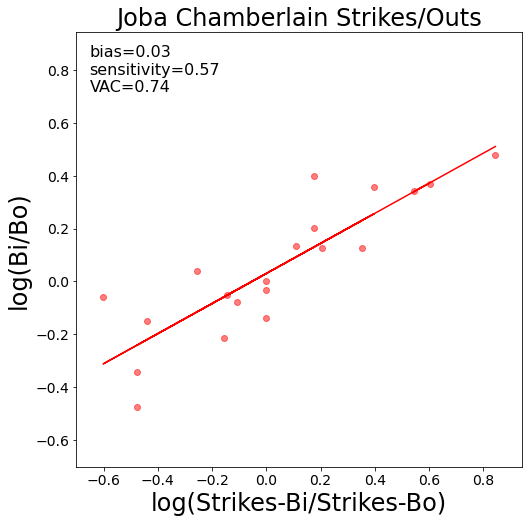

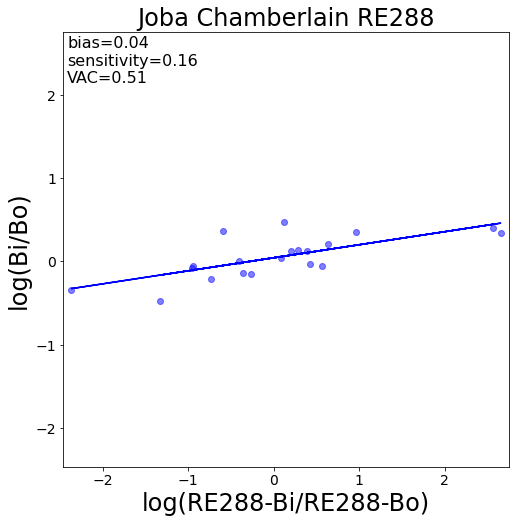

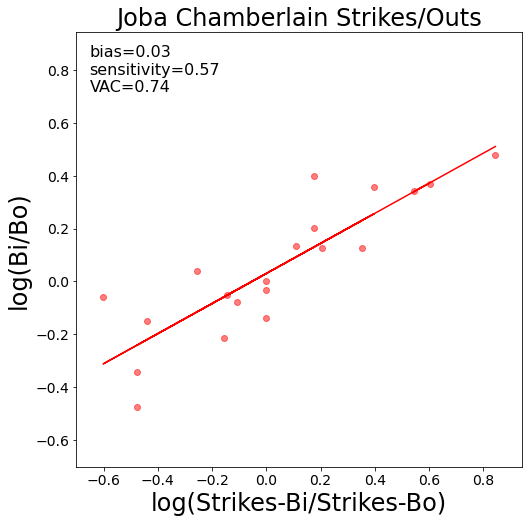

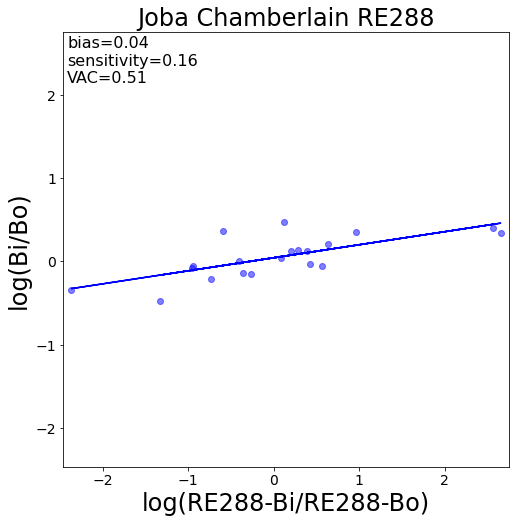

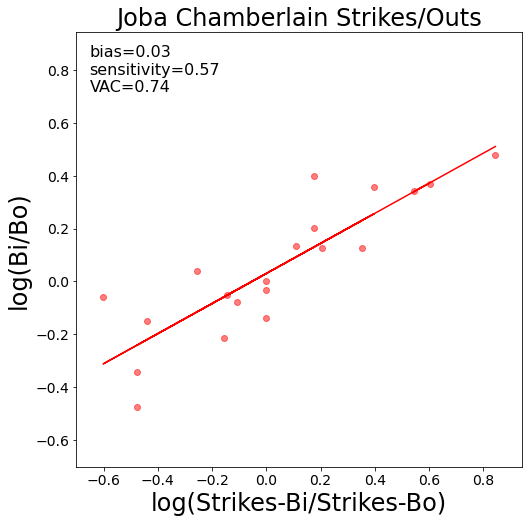

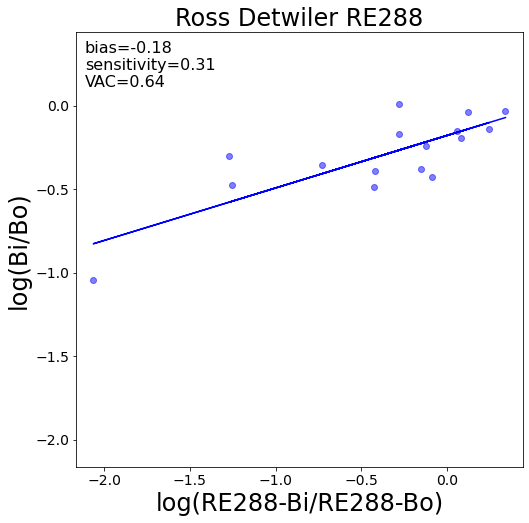

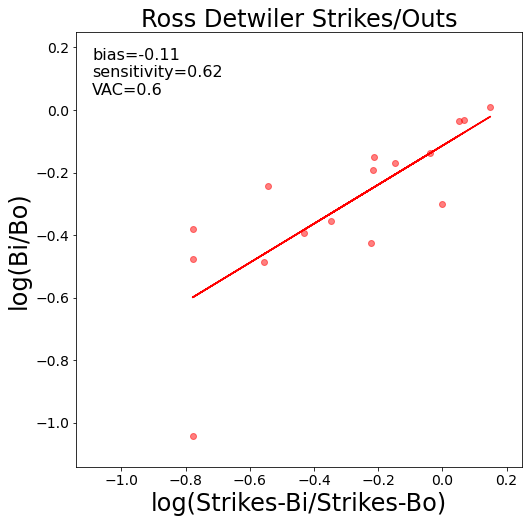

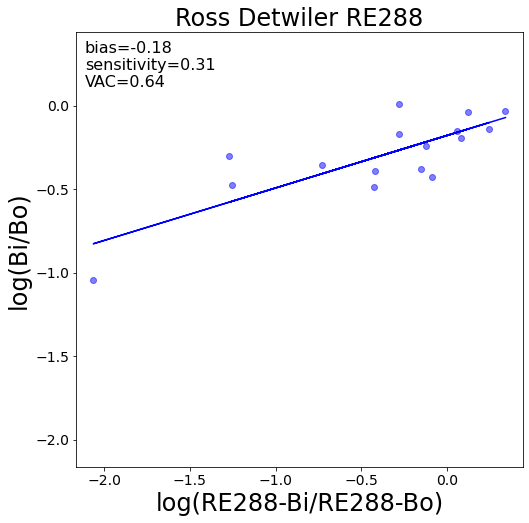

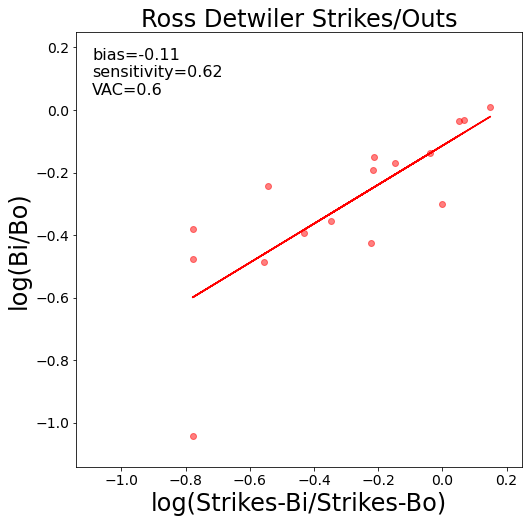

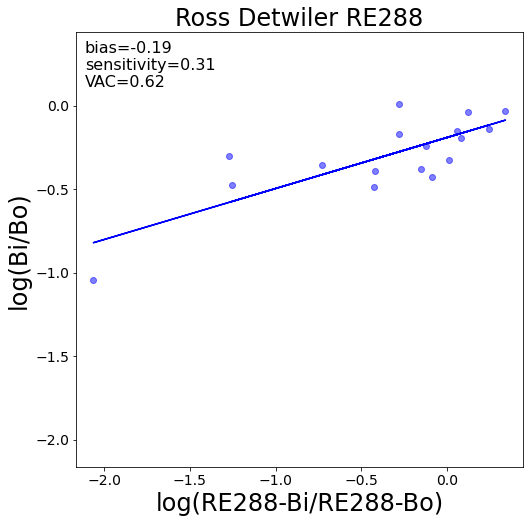

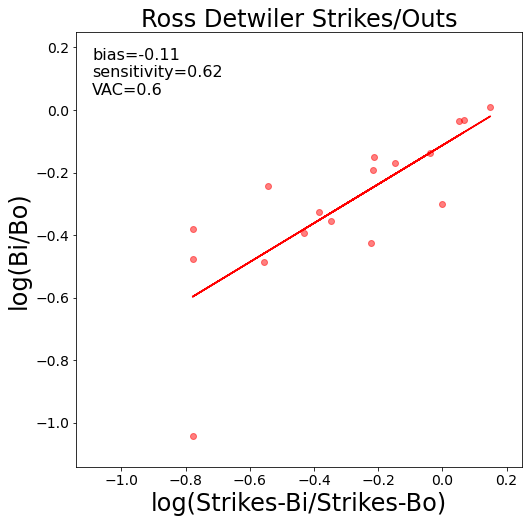

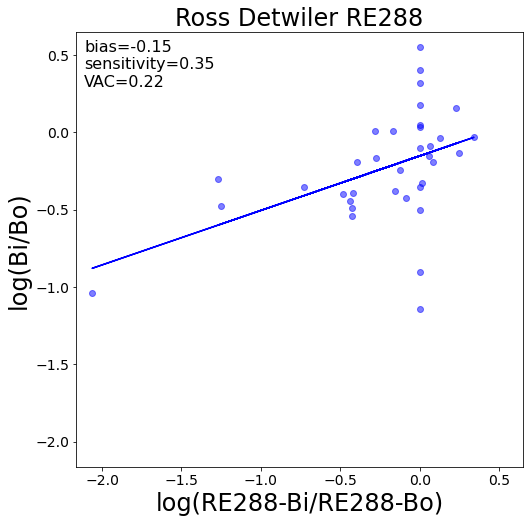

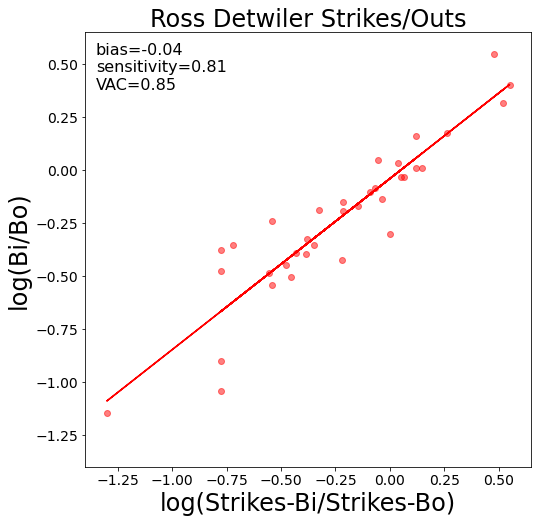

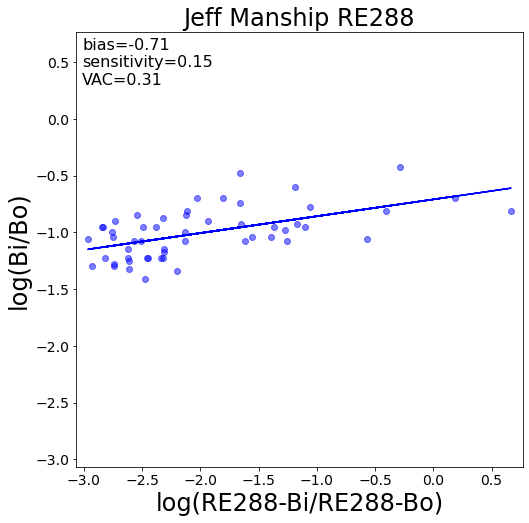

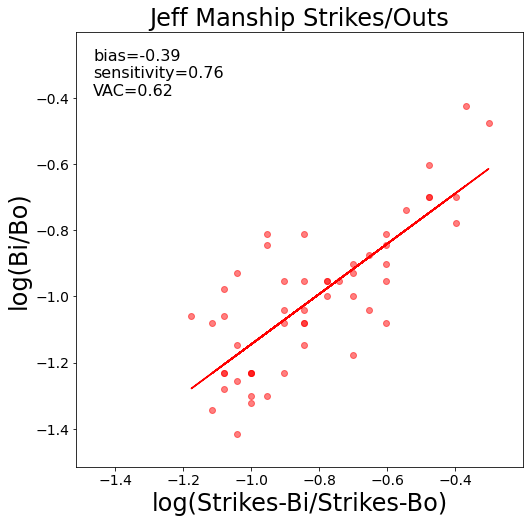

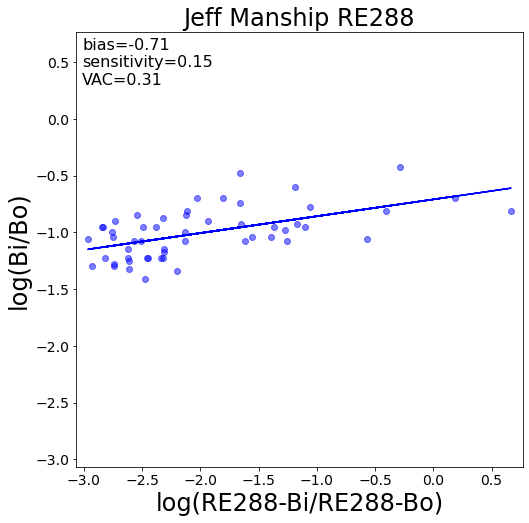

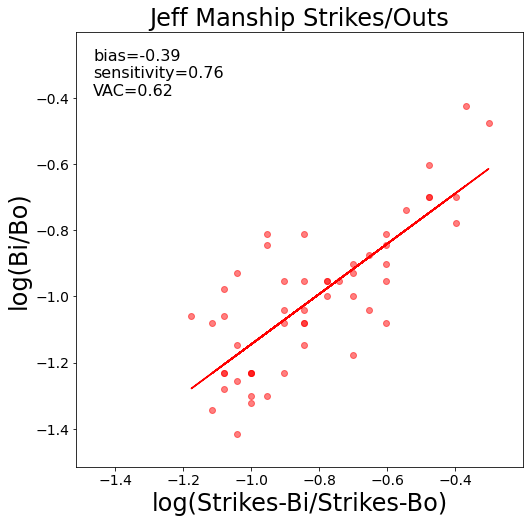

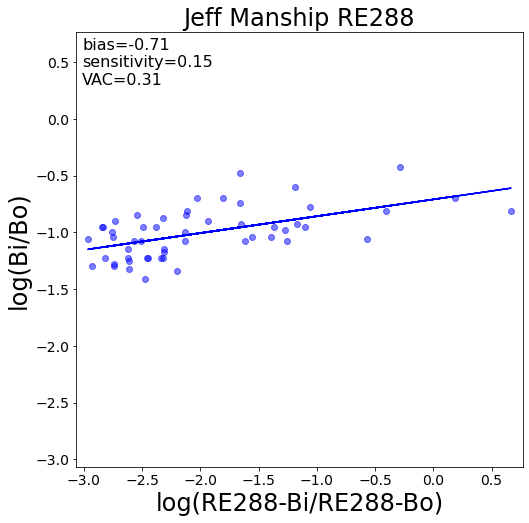

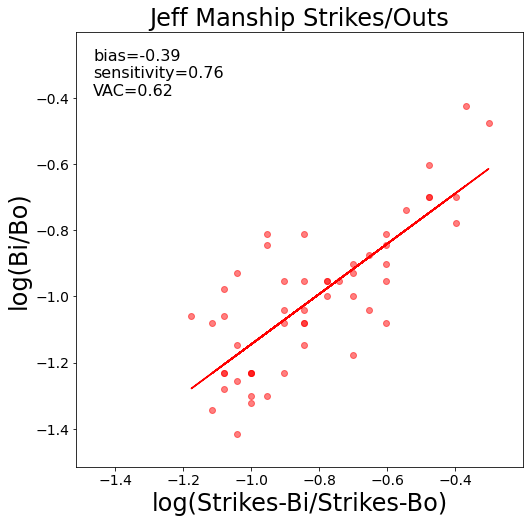

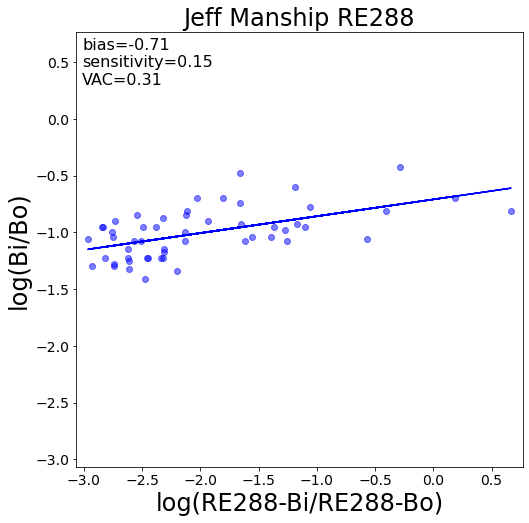

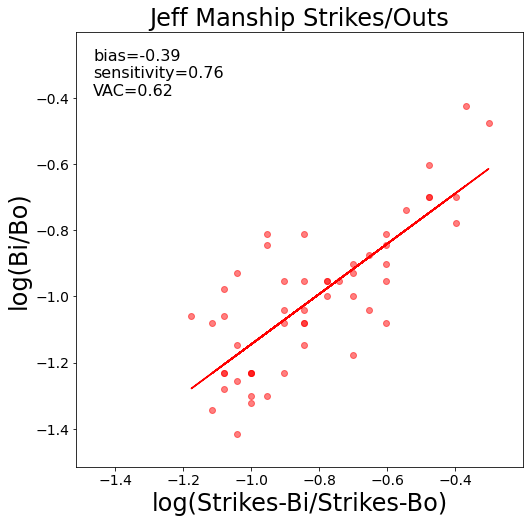

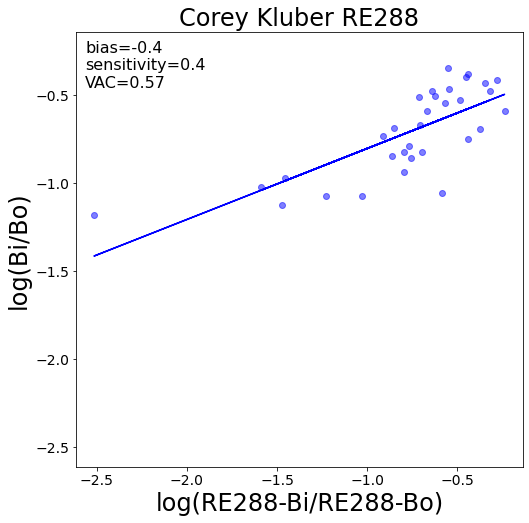

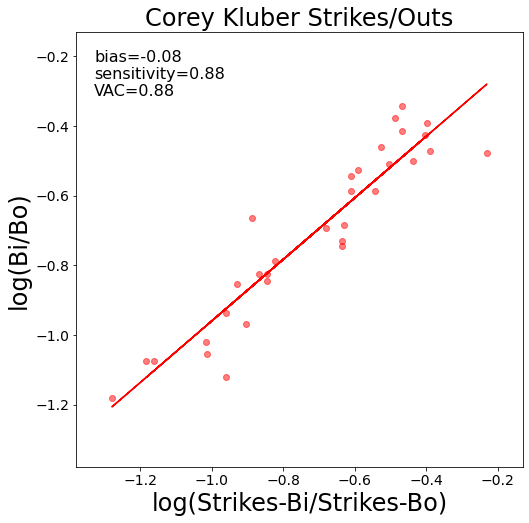

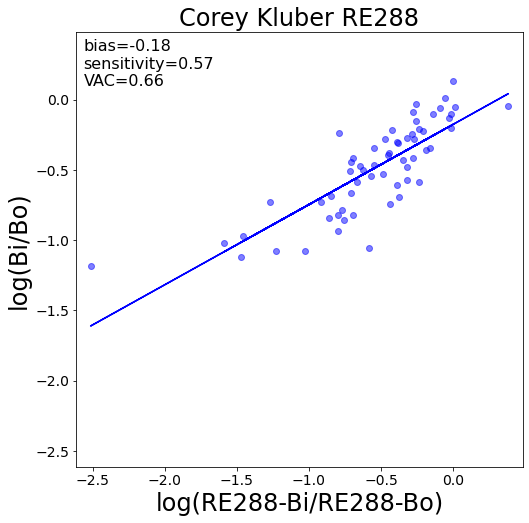

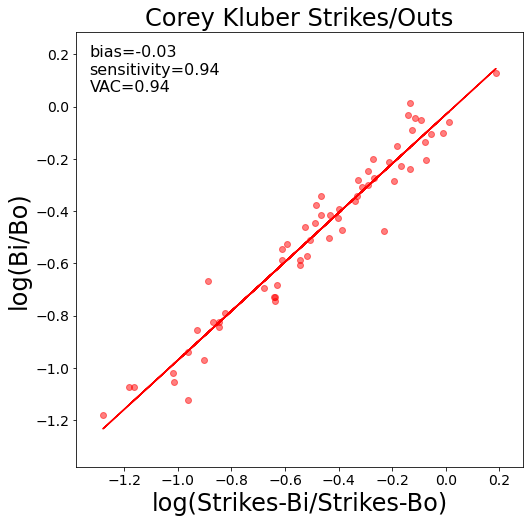

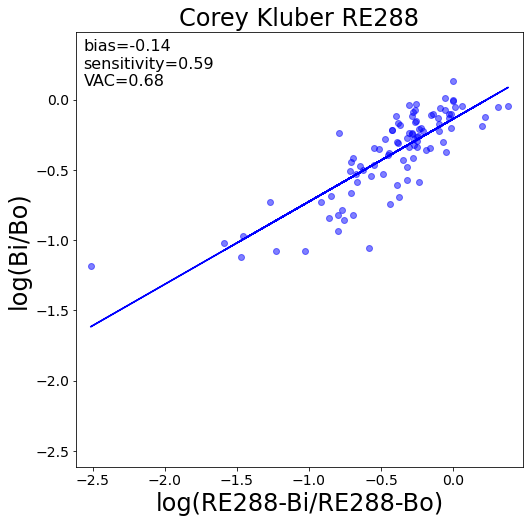

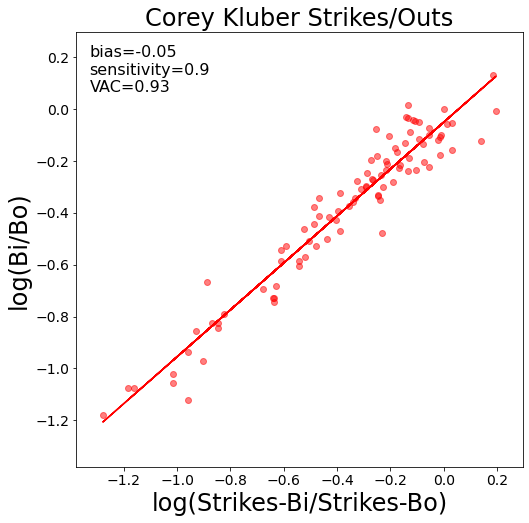

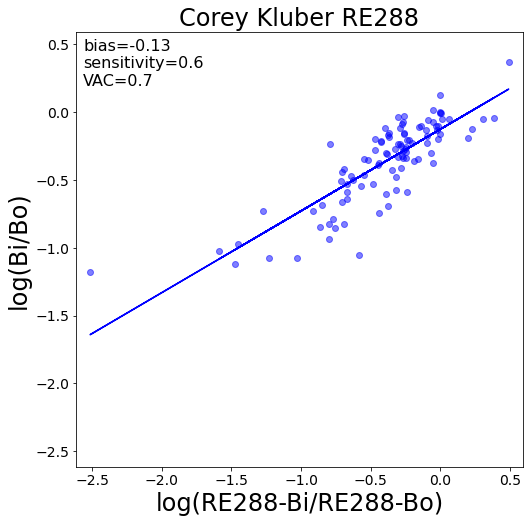

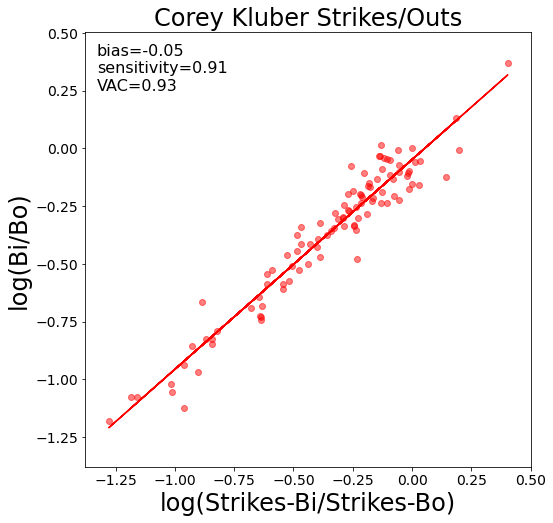

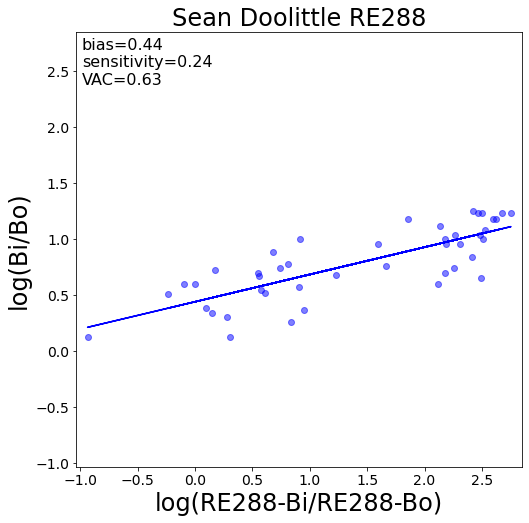

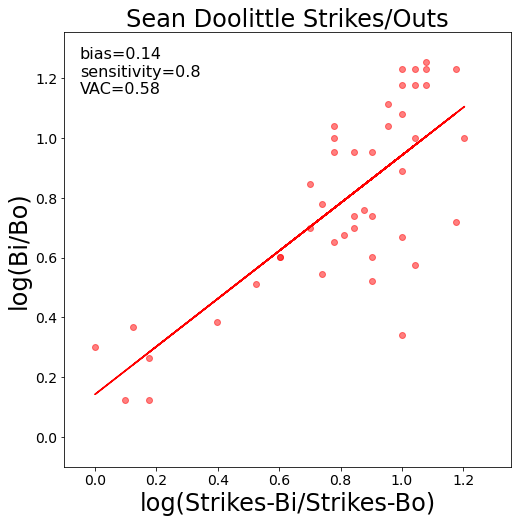

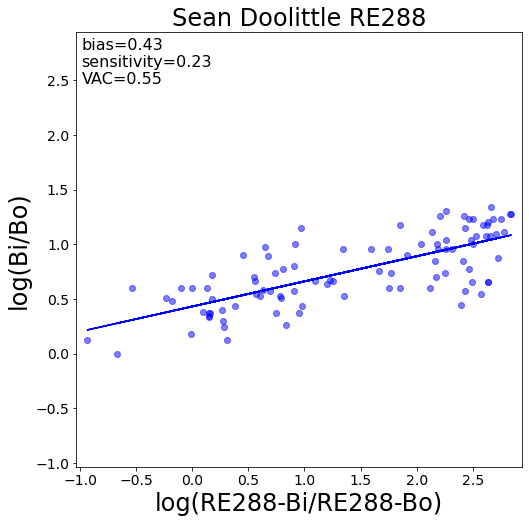

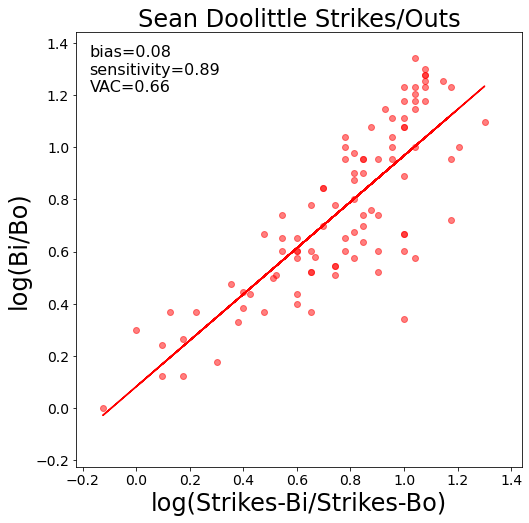

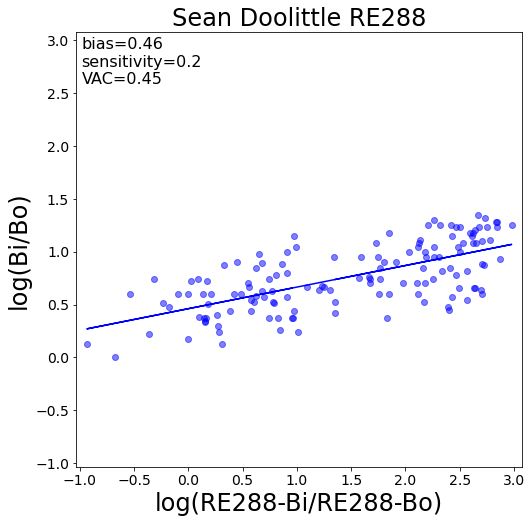

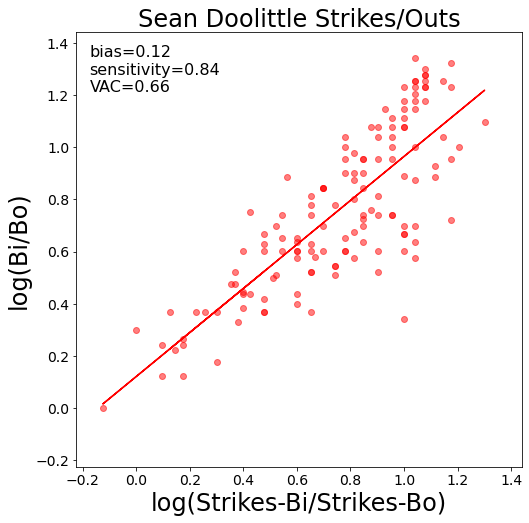

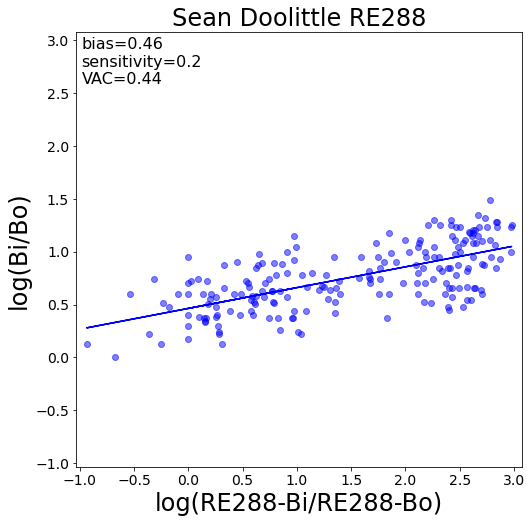

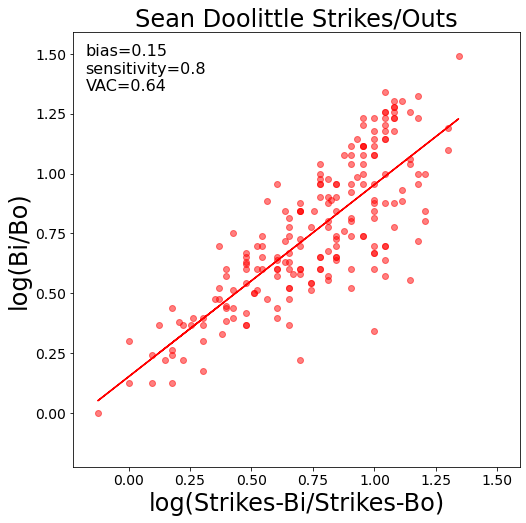

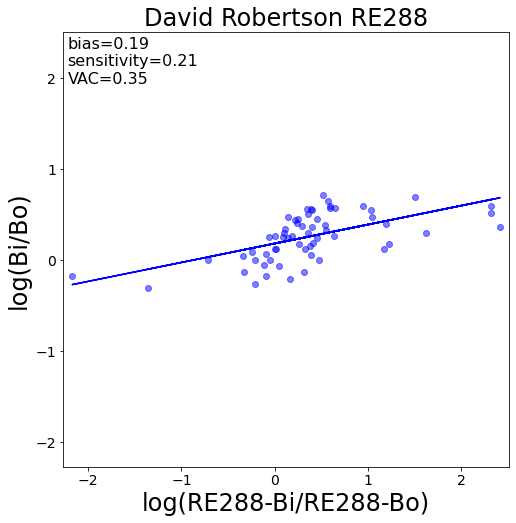

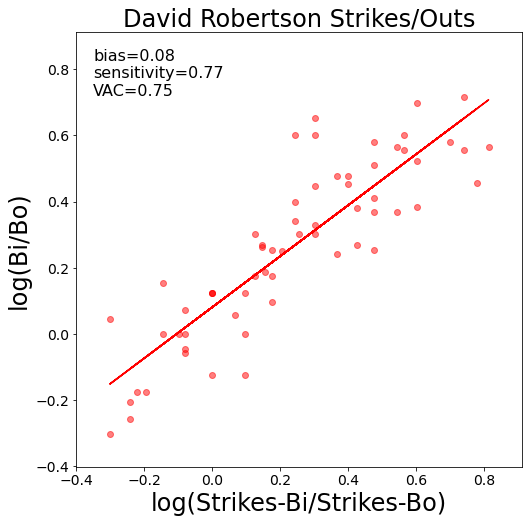

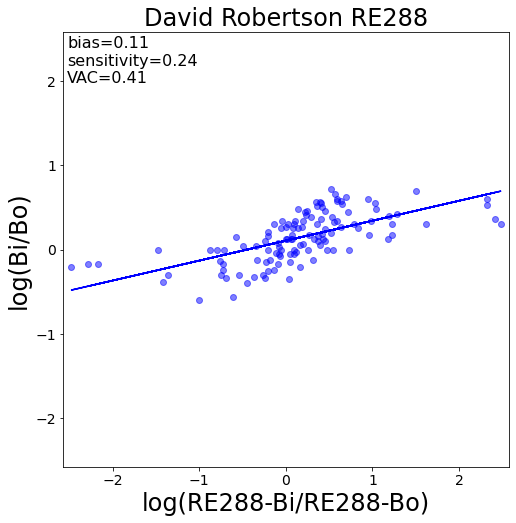

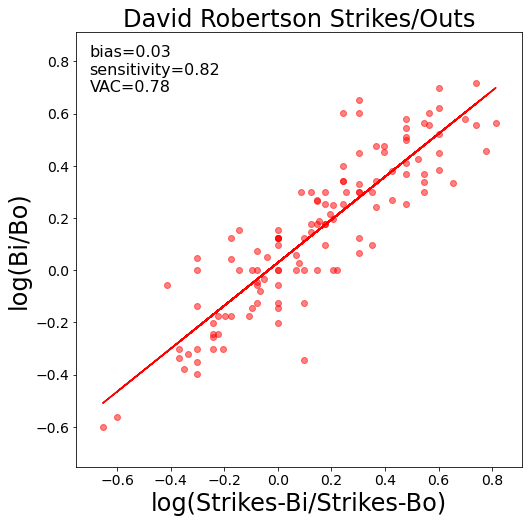

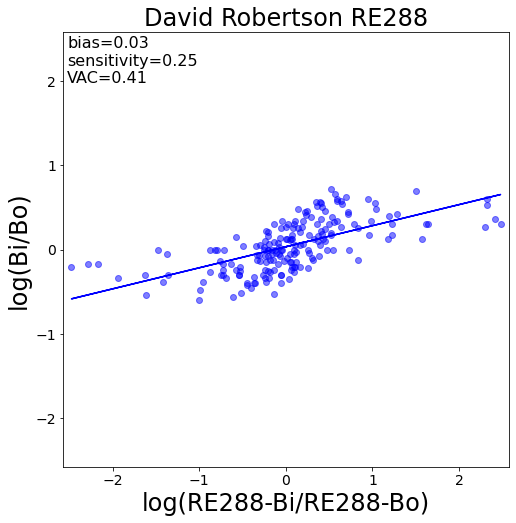

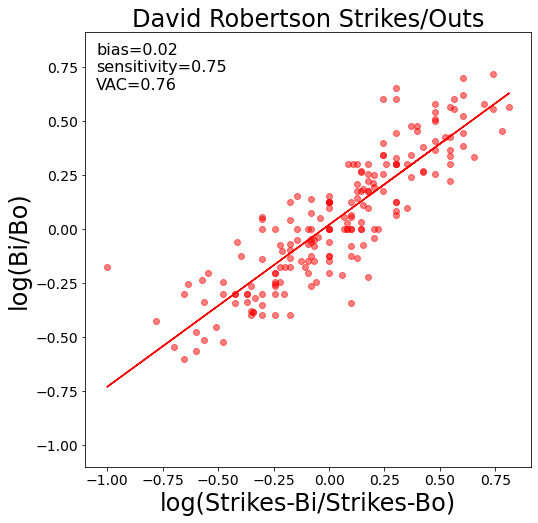

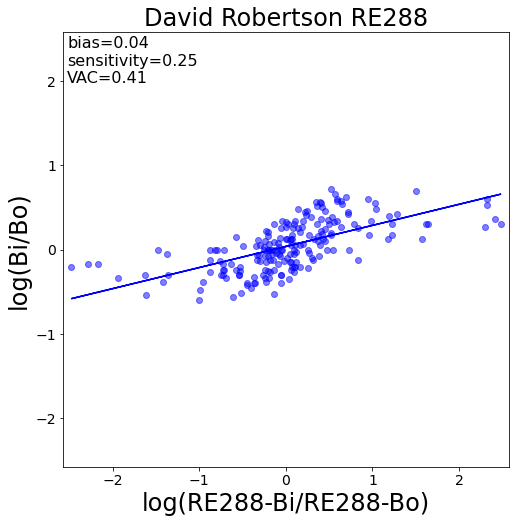

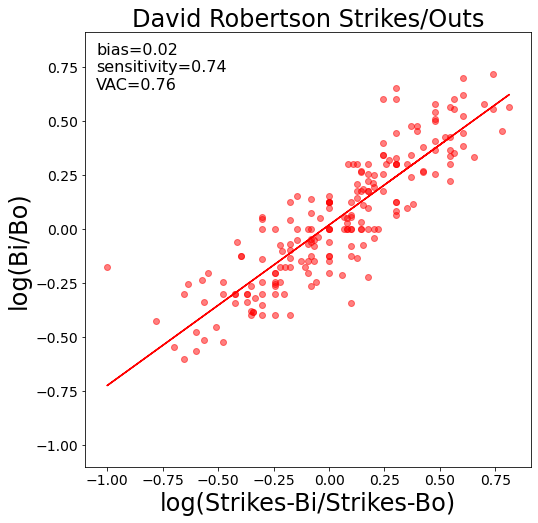

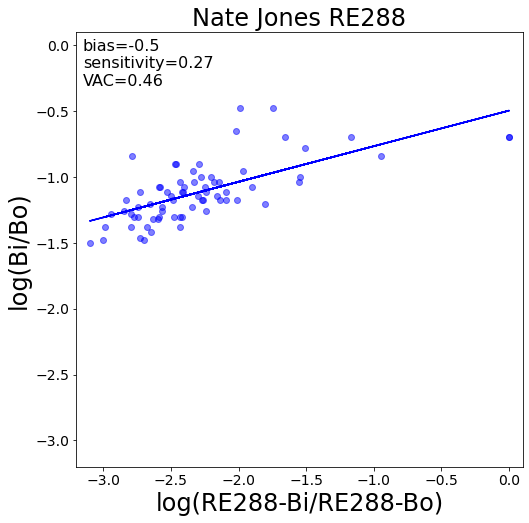

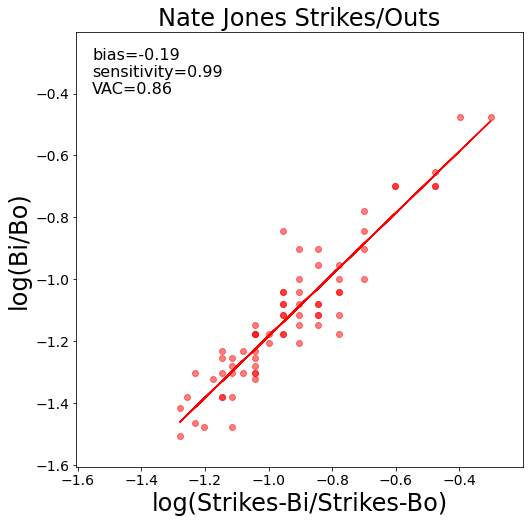

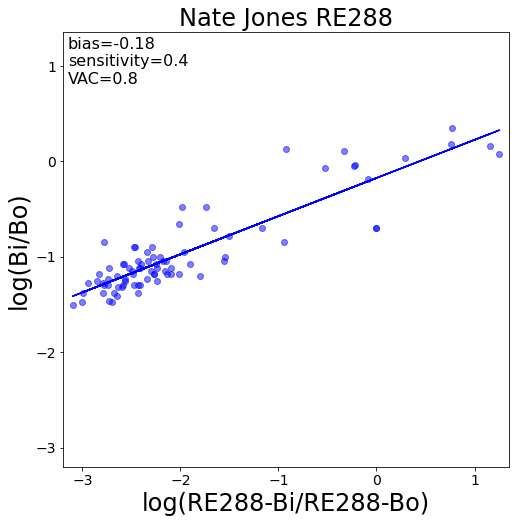

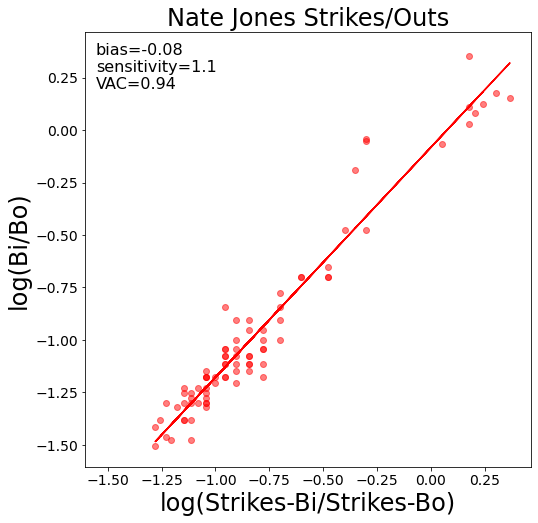

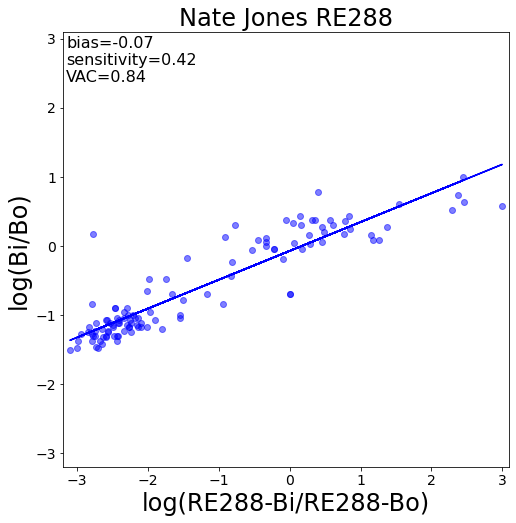

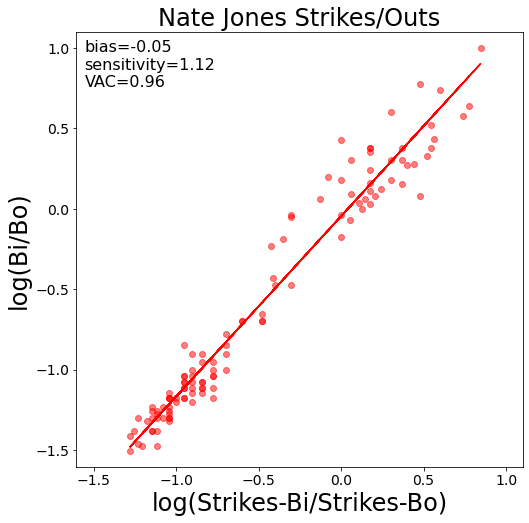

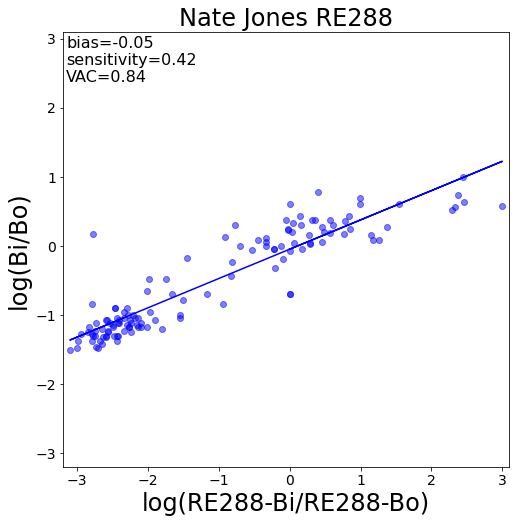

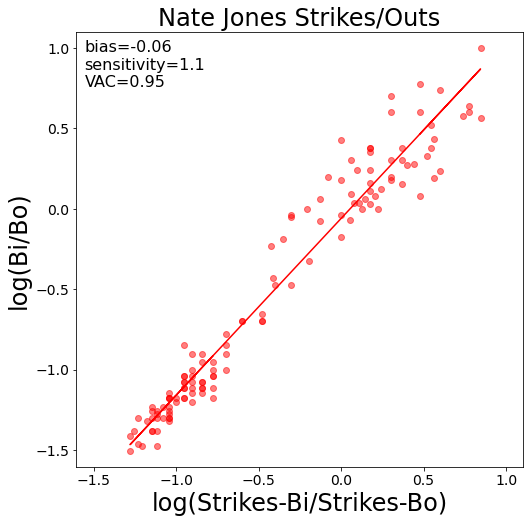

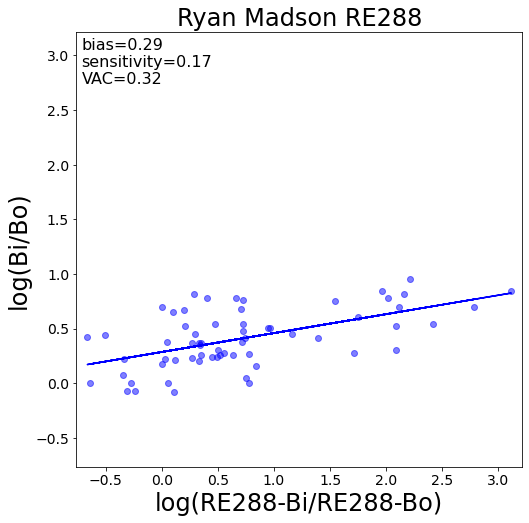

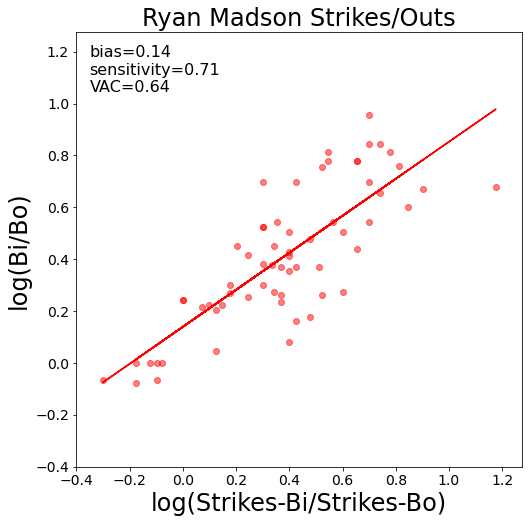

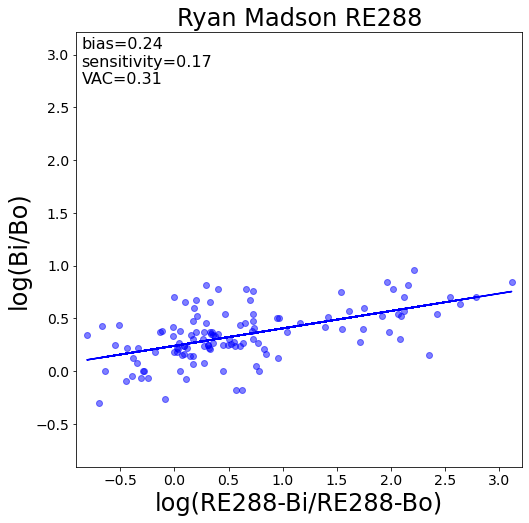

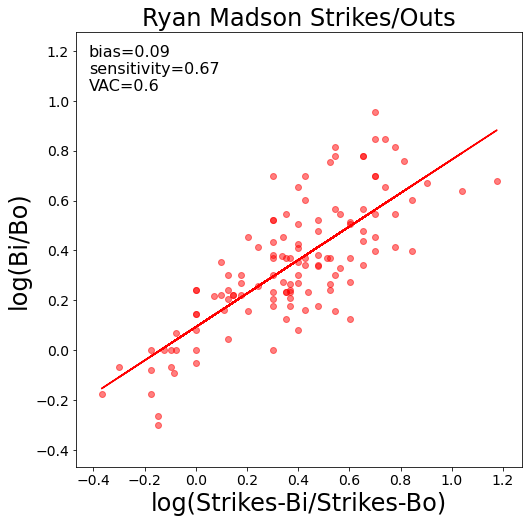

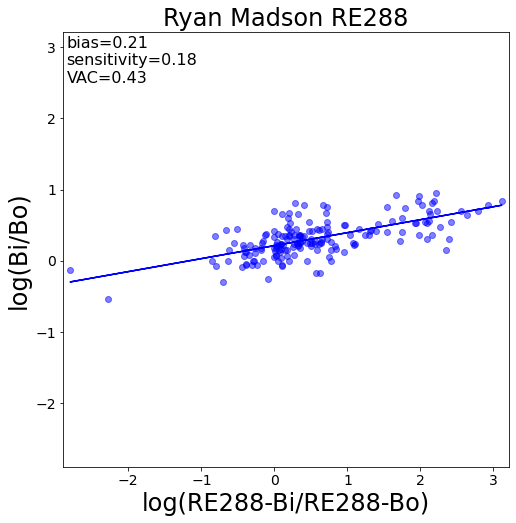

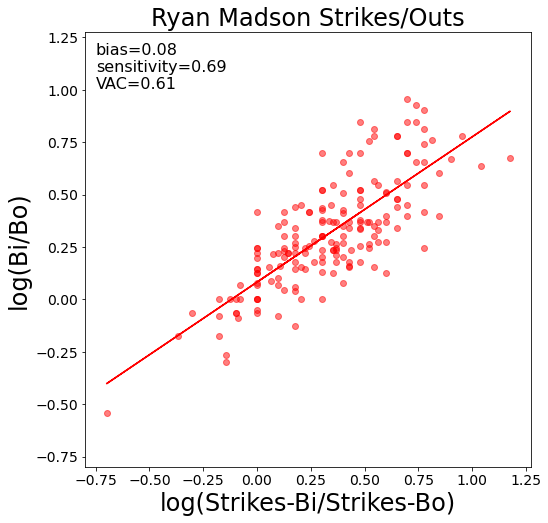

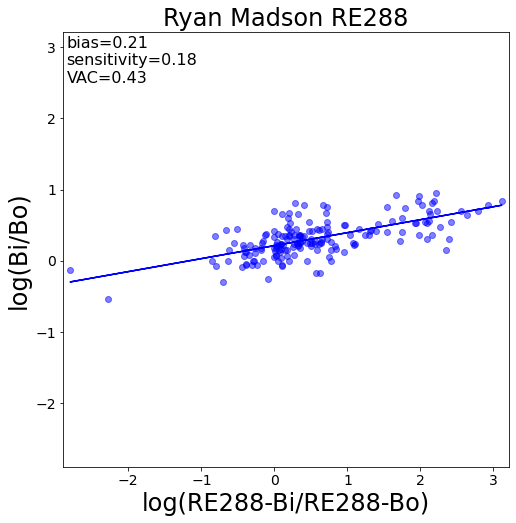

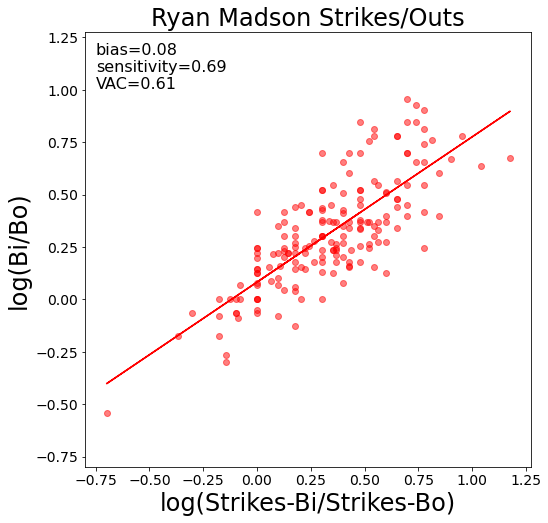

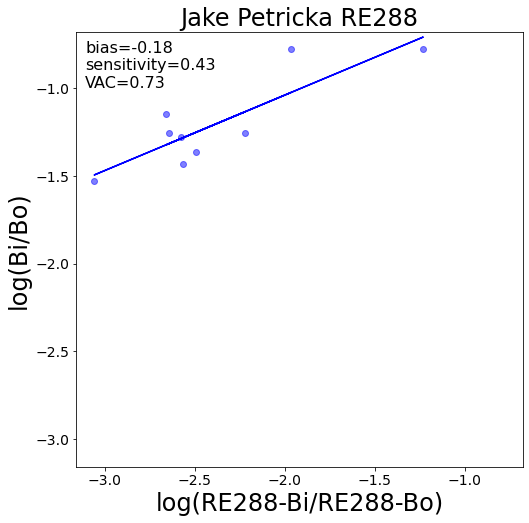

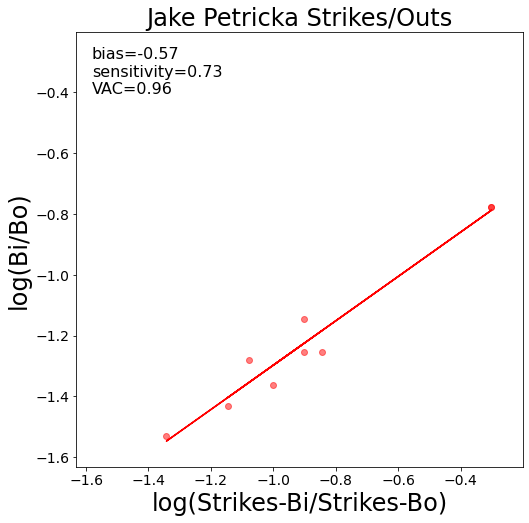

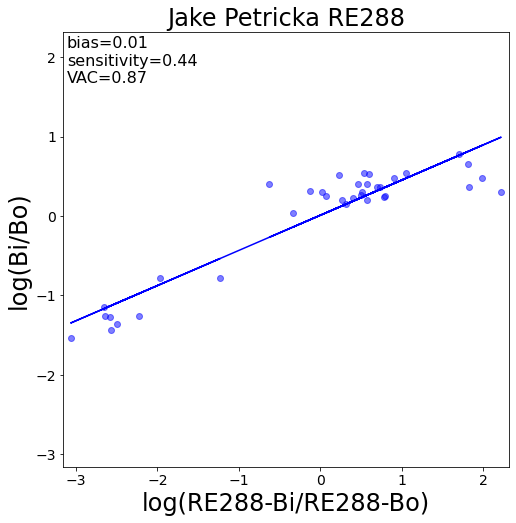

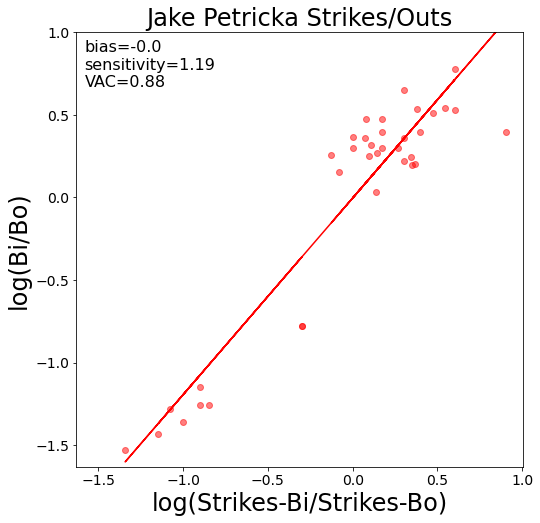

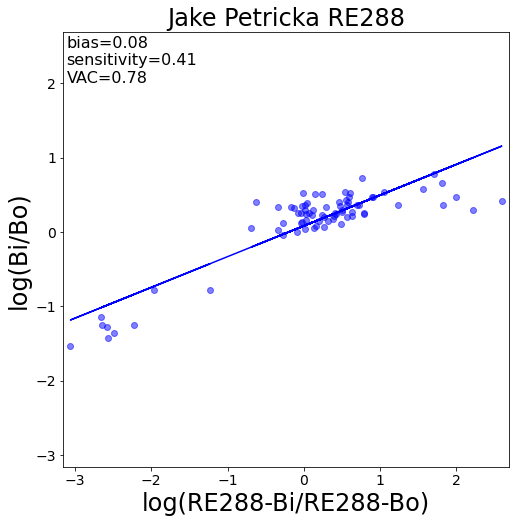

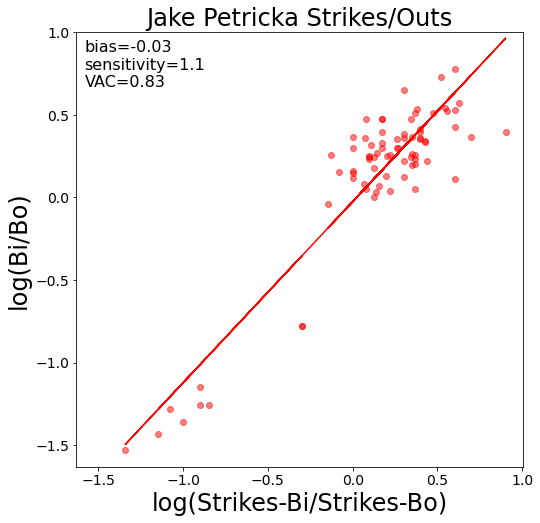

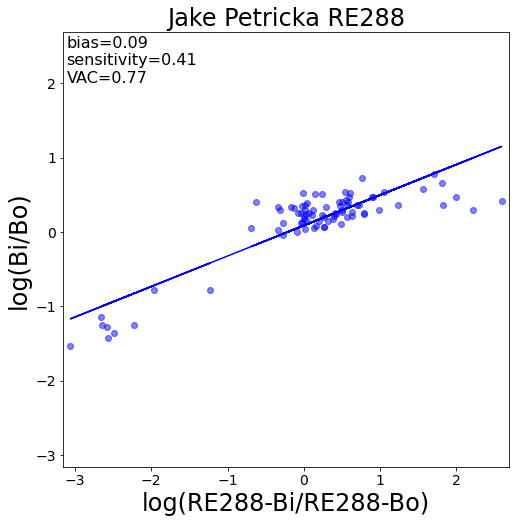

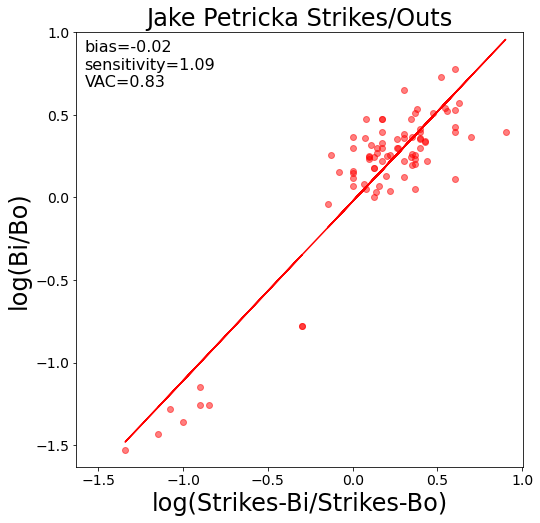

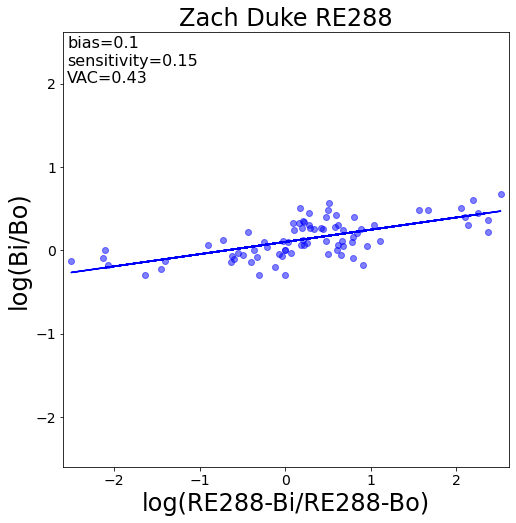

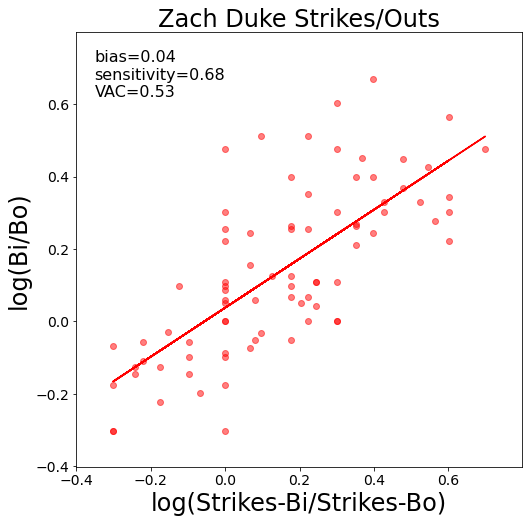

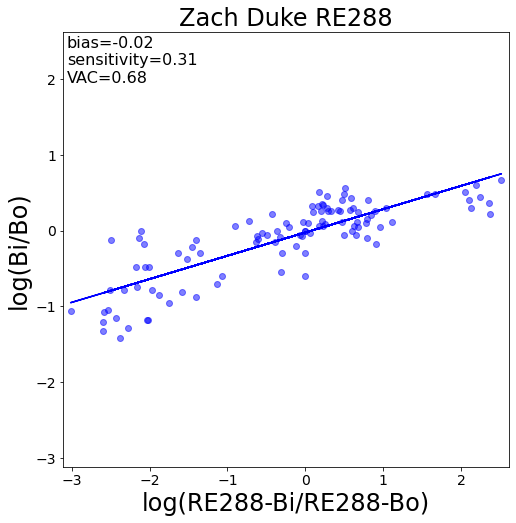

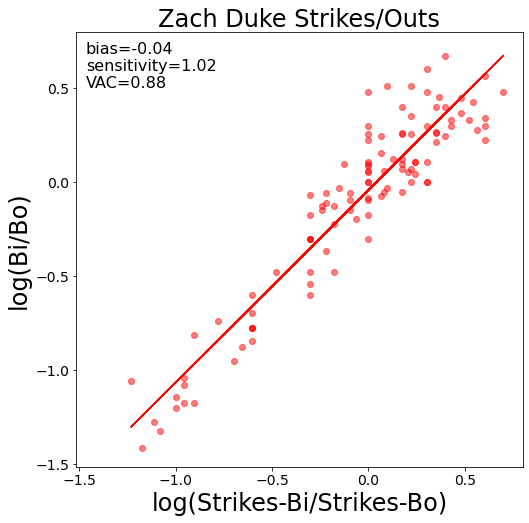

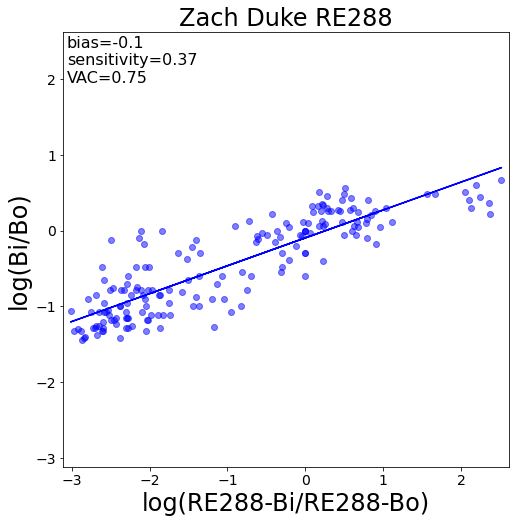

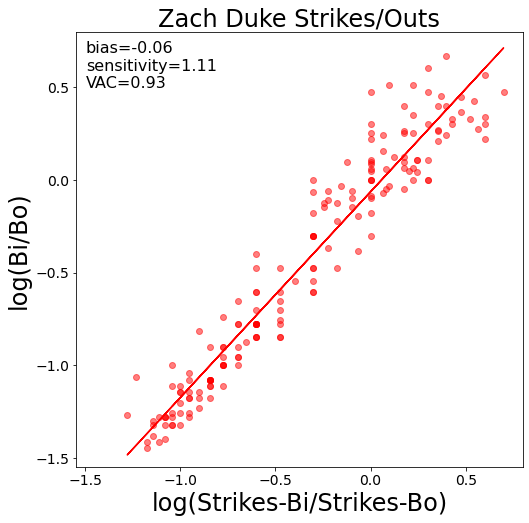

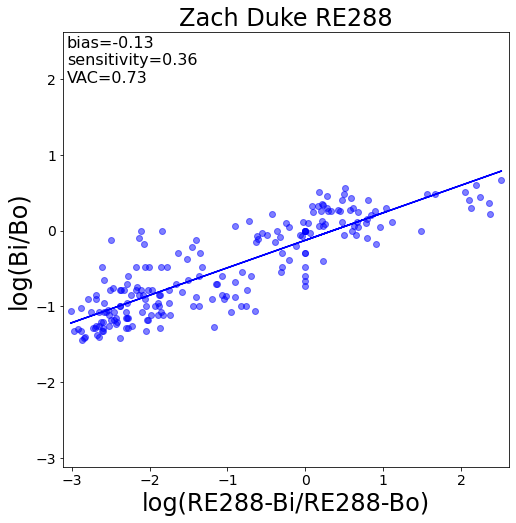

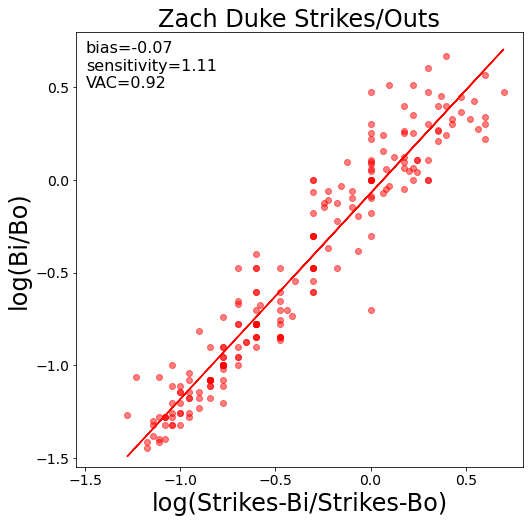

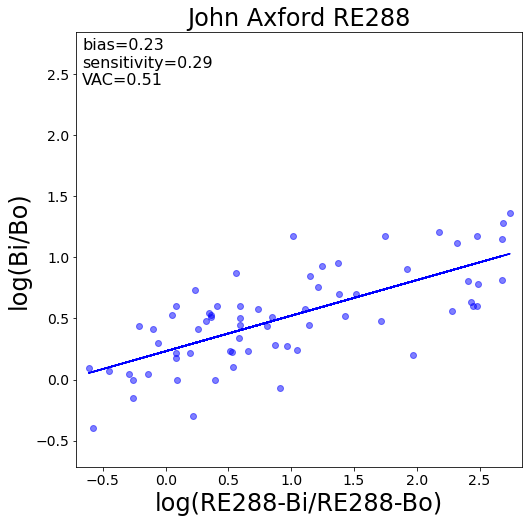

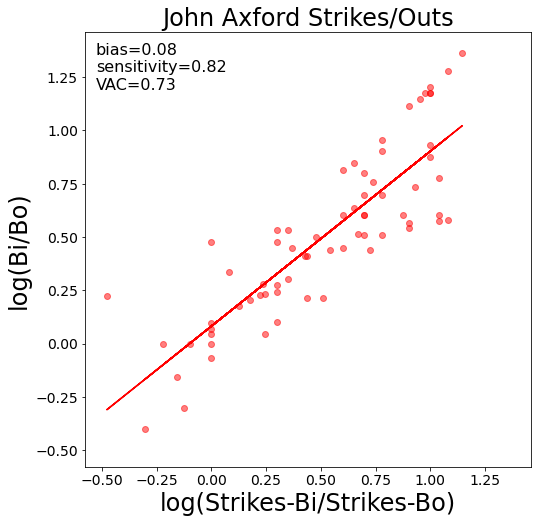

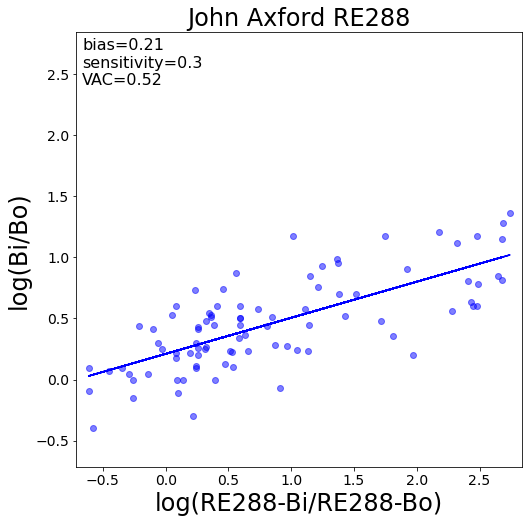

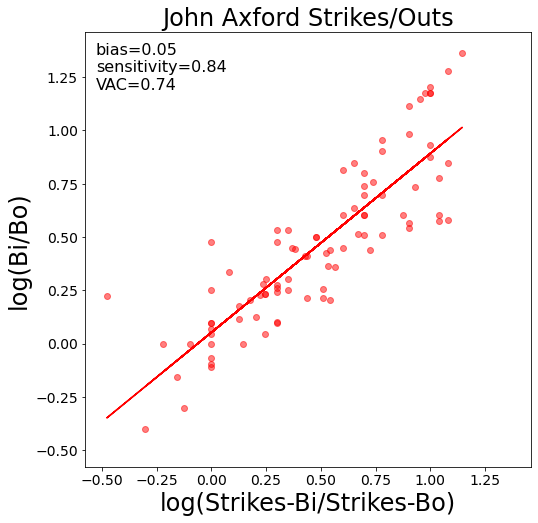

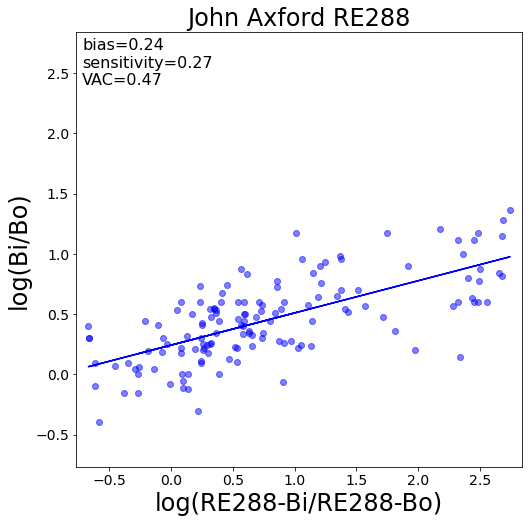

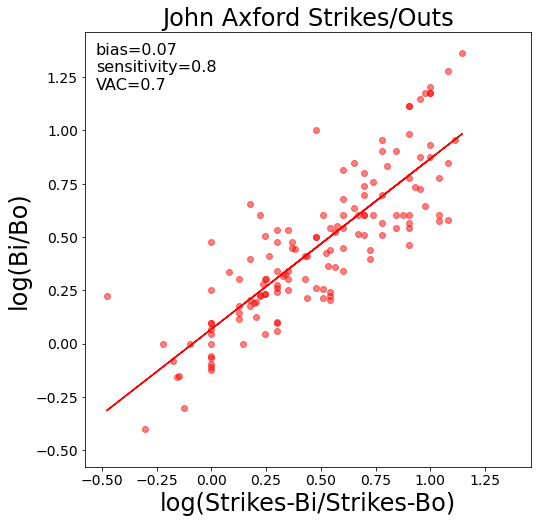

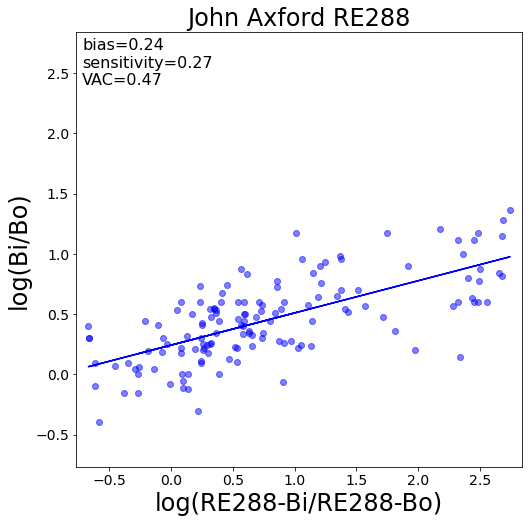

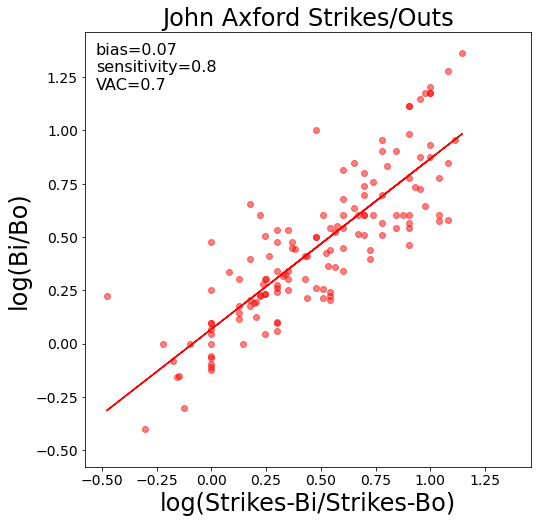

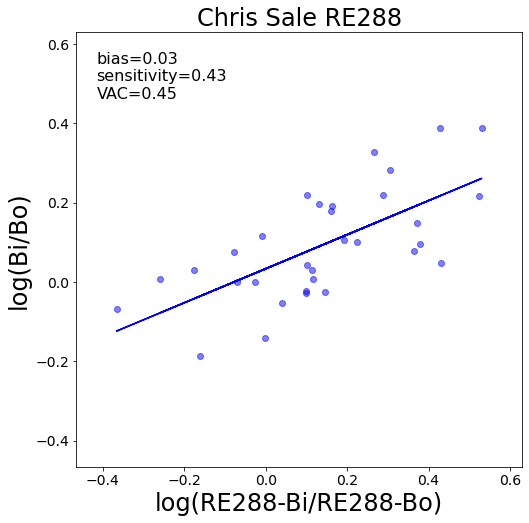

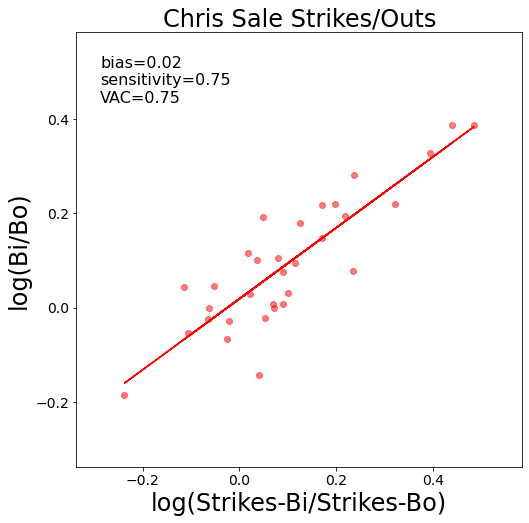

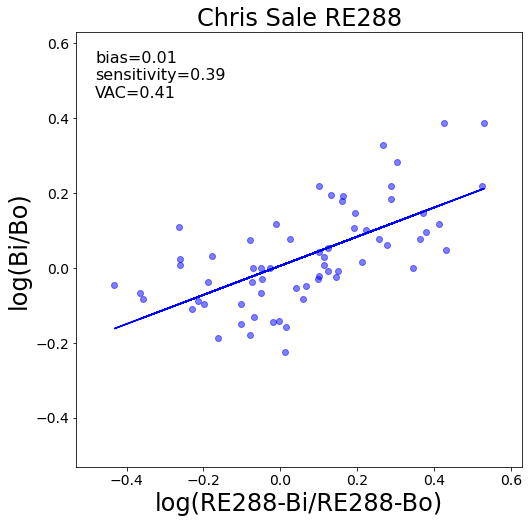

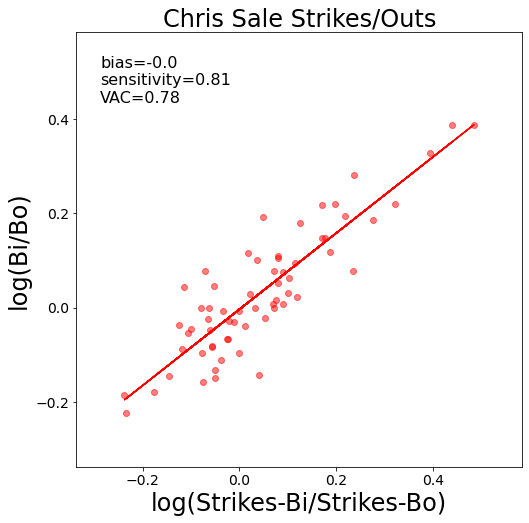

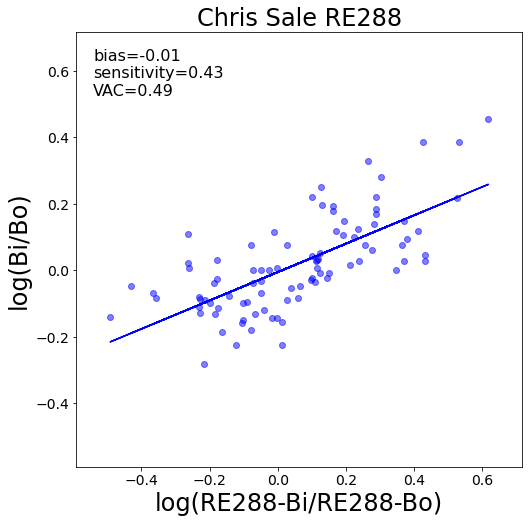

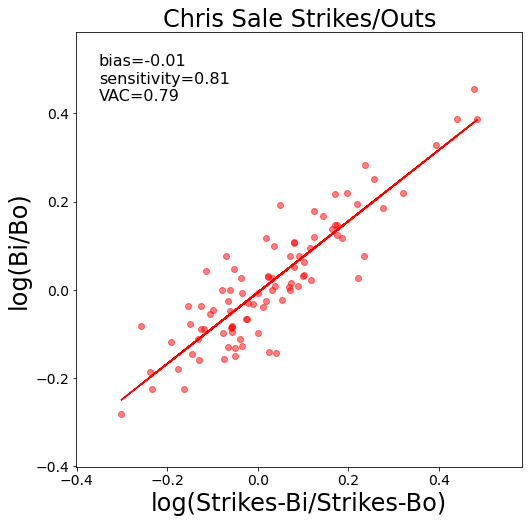

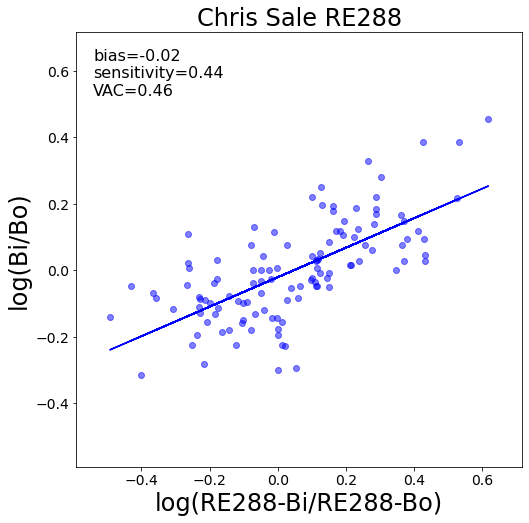

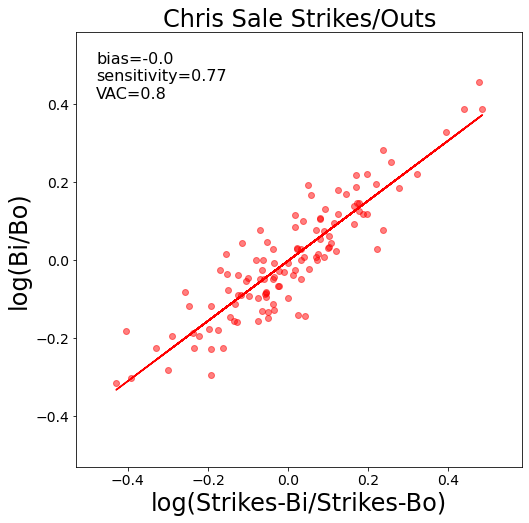

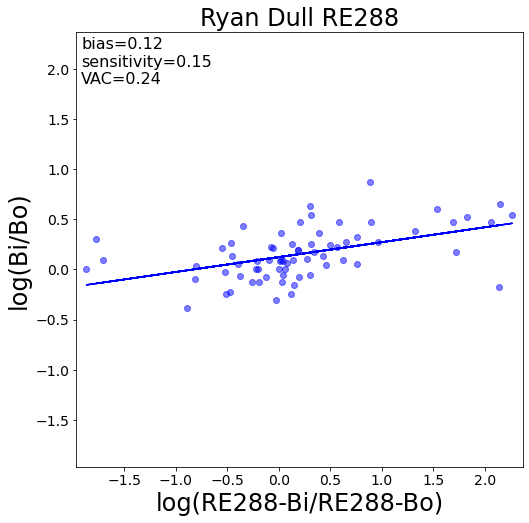

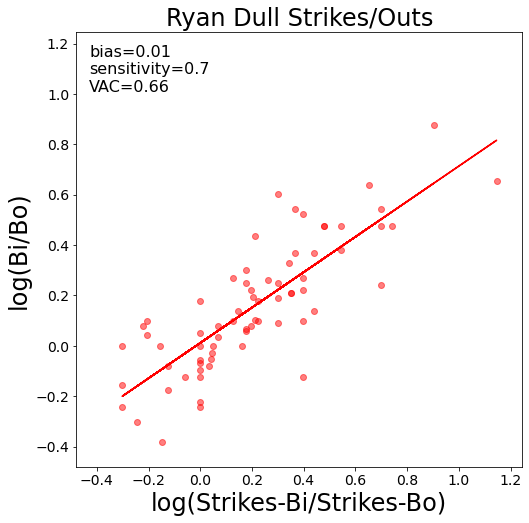

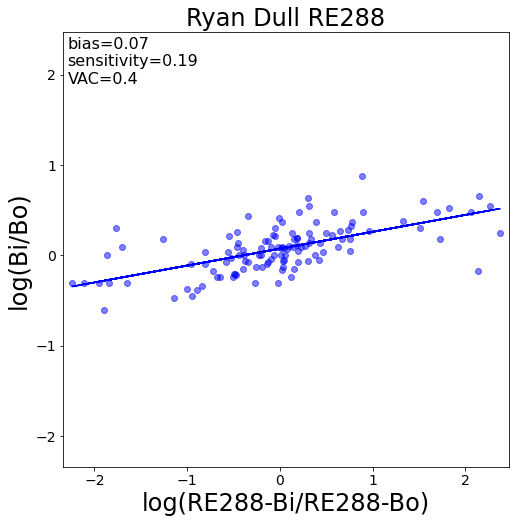

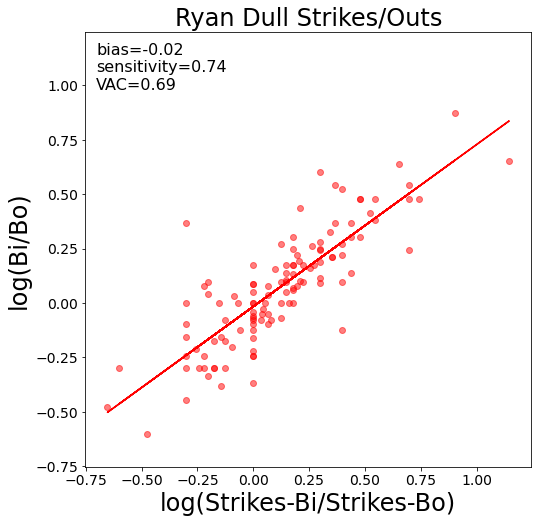

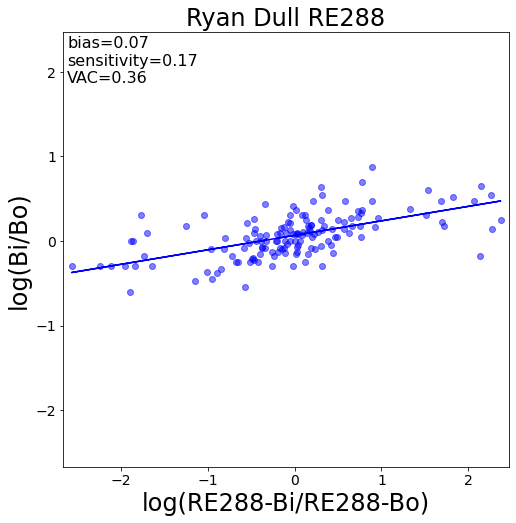

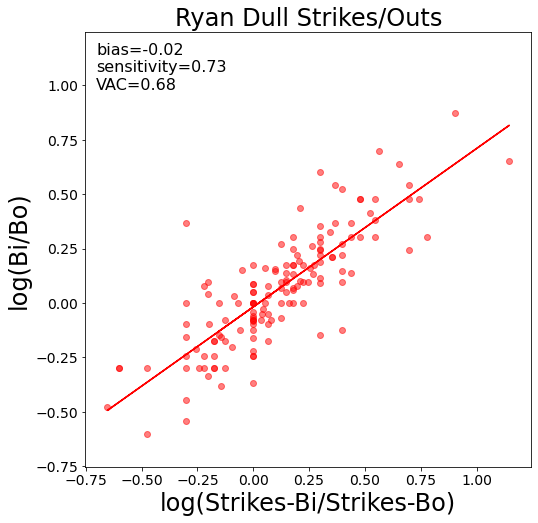

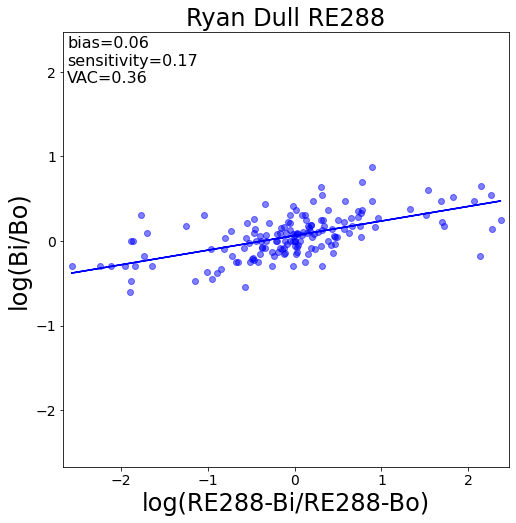

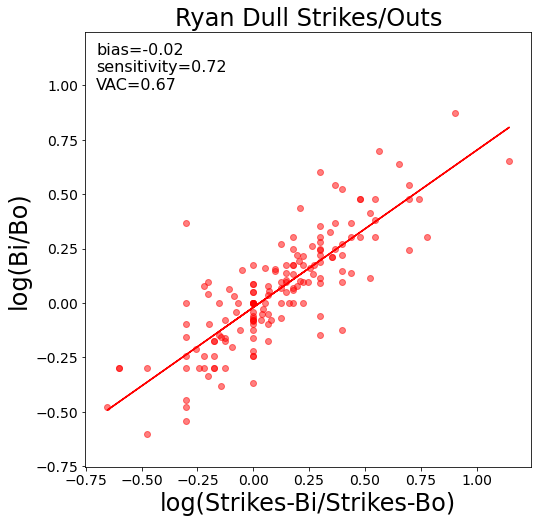

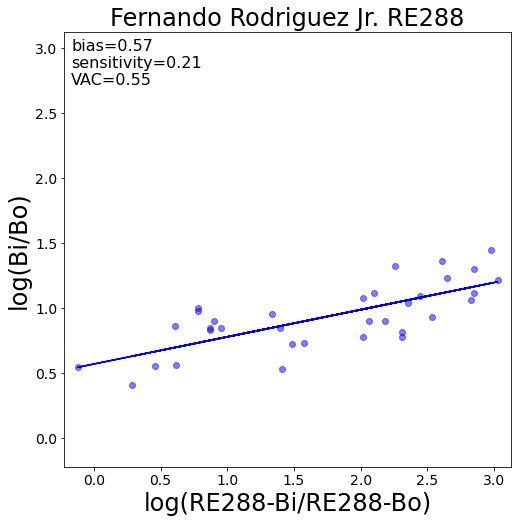

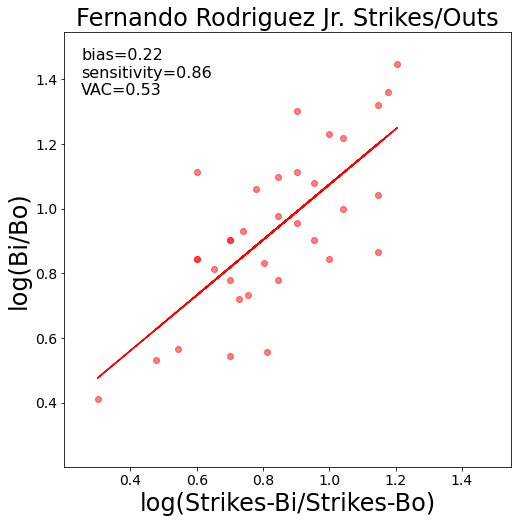

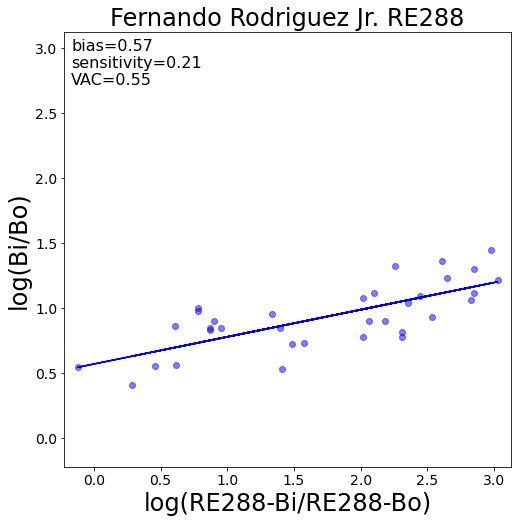

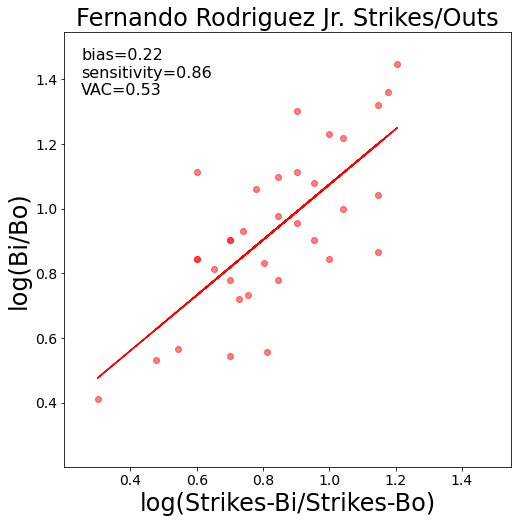

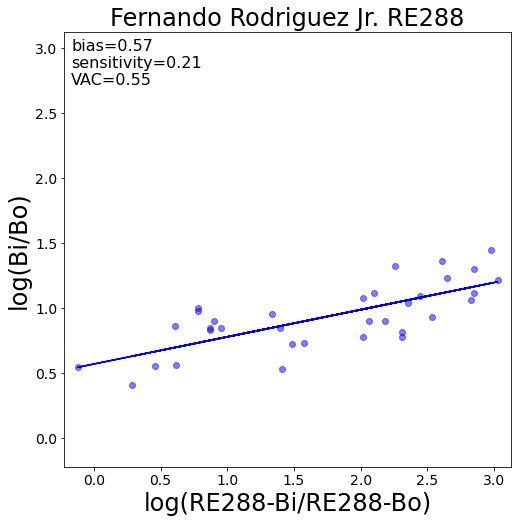

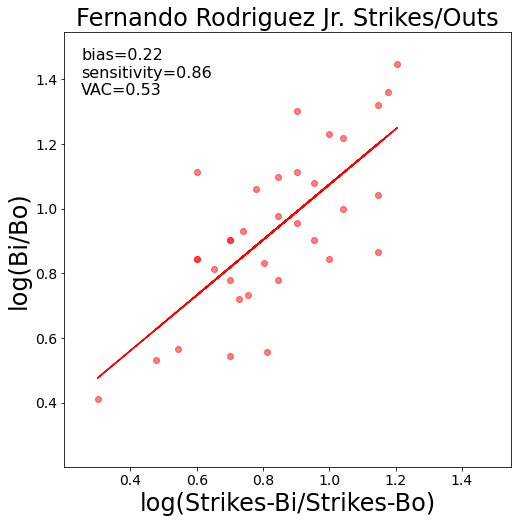

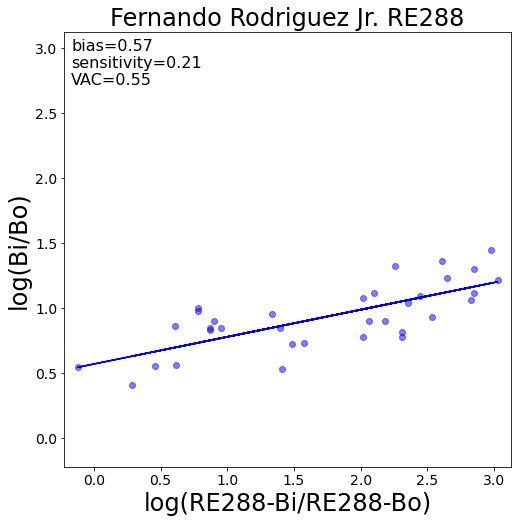

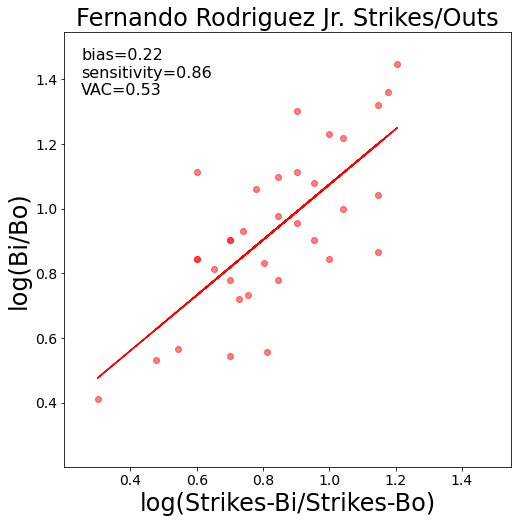

In [118]:
# Calculate GME for each pitcher in df using RE288 as outcome
# Make sure data types are as we need them
data.game_year = data.game_year.astype(int)

player = []
season = []
VAC_RE288 = []
bias_RE288 = []
sens_RE288 = []
VAC_strikes = []
bias_strikes = []
sens_strikes = []
player_count = 0

# Pull df for the target pitcher and break down by season
for i in uniq_p:
  # Lists to store things in
  game_number = []
  year = []
  hard_straight_count = []
  hard_breaking_count = []
  soft_straight_count = []
  soft_breaking_count = []
  hard_straight_re288 = []
  hard_breaking_re288 = []
  soft_straight_re288 = []
  soft_breaking_re288 = []
  hard_straight_s_o = []
  hard_breaking_s_o = []
  soft_straight_s_o = []
  soft_breaking_s_o = []

  df = data[data['player_name']==i]

  for j in [2016, 2017, 2018, 2019]:
    df_year = df[df['game_year']==j]
    g_uniq = df_year['game_date'].unique()
    gnum = 1
    for k in g_uniq:
      game_data = df_year[df_year['game_date']==k]
      
      # Create dfs for each pitch type
      hard_straight = game_data.loc[game_data.pitch_name.isin(hrd_strt)]
      hard_breaking = game_data.loc[game_data.pitch_name.isin(hrd_brkng)]
      soft_straight = game_data.loc[game_data.pitch_name.isin(sft_strt)]
      soft_breaking = game_data.loc[game_data.pitch_name.isin(sft_brkng)]
      
      # Get the count of each pitch type per game
      hstrt = len(hard_straight)
      hbrk = len(hard_breaking)
      sstrt = len(soft_straight)
      sbrk = len(soft_breaking)
      
      # Get the sum of RE288 by pitch type for each game
      hstrt288 = hard_straight.loc[hard_straight['RE288_change']>0]
      hbrk288  = hard_breaking.loc[hard_breaking['RE288_change']>0]
      sstrt288 = soft_straight.loc[soft_straight['RE288_change']>0]
      sbrk288  = soft_breaking.loc[soft_breaking['RE288_change']>0]
      hstrt288 = hstrt288['RE288_change'].sum()
      hbrk288  = hbrk288['RE288_change'].sum()      
      sstrt288 = sstrt288['RE288_change'].sum()
      sbrk288  = sbrk288['RE288_change'].sum()

      # Get the count of strikes/outs that followed each pitch type per game
      hstrt_strike = len(hard_straight.loc[hard_straight.description.isin(s_o)])
      hbrk_strike = len(hard_breaking.loc[hard_breaking.description.isin(s_o)])
      sstrt_strike = len(soft_straight.loc[soft_straight.description.isin(s_o)])
      sbrk_strike = len(soft_breaking.loc[soft_breaking.description.isin(s_o)])
      
      # Append the vals to the respective lists
      game_number.append(gnum)
      gnum += 1
      year.append(j)
      # Pitches
      hard_straight_count.append(hstrt)
      hard_breaking_count.append(hbrk)
      soft_straight_count.append(sstrt)
      soft_breaking_count.append(sbrk)
      # RE288
      hard_straight_re288.append(hstrt288)
      hard_breaking_re288.append(hbrk288)
      soft_straight_re288.append(sstrt288)
      soft_breaking_re288.append(sbrk288)
      # Strikes/outs
      hard_straight_s_o.append(hstrt_strike)
      hard_breaking_s_o.append(hbrk_strike)
      soft_straight_s_o.append(sstrt_strike)
      soft_breaking_s_o.append(sbrk_strike)
        
    # Log pitch and outcome ratios using fastball as Bi
    logged_bx = []
    logged_RE288 = []
    logged_strikes = []

    for l in list(range(len(hard_straight_count))):
      behavior = (hard_straight_count[l]+1)/(hard_breaking_count[l] + soft_straight_count[l] + soft_breaking_count[l]+1)
      RE288 = (hard_straight_re288[l]+.001)/(hard_breaking_re288[l] + soft_straight_re288[l] + soft_breaking_re288[l]+.001)
      strikes = (hard_straight_s_o[l]+1)/(hard_breaking_s_o[l] + soft_straight_s_o[l] + soft_breaking_s_o[l]+1)
      behavior = math.log(behavior, 10)
      RE288 = math.log(RE288, 10)
      strikes = math.log(strikes, 10)
      logged_bx.append(behavior)
      logged_RE288.append(RE288)
      logged_strikes.append(strikes)
    
    # Combine the lists and save df for the pitcher
    count_data = pd.DataFrame({'Year':year, 'Game': game_number, \
                               'HStrt': hard_straight_count, 'HBrk':hard_breaking_count, \
                               'SStrt':soft_straight_count,'SBrk':soft_breaking_count, \
                               'HStrtRE288':hard_straight_re288, 'HBrkRE288':hard_breaking_re288, \
                               'SStrtRE288':soft_straight_re288, 'SBrkRE288':soft_straight_re288, \
                               'HStrtStrike':hard_straight_s_o, 'HBrkStrike':hard_breaking_s_o, \
                               'SStrtStrike':soft_straight_s_o, 'SBrkStrike':soft_breaking_s_o, \
                               'Logged_Bx':logged_bx, 'Logged_RE288':logged_RE288, \
                               'Logged_Strikes':logged_strikes})
    count_data = count_data.fillna(0)

    # Save the player data
    count_data.to_csv('%s_counts.csv' %i)

    # Fit the GME and return the parameters
    s_288, b_288 = np.polyfit(count_data.Logged_RE288, count_data.Logged_Bx, 1)
    corrmat288 = np.corrcoef(count_data.Logged_RE288, count_data.Logged_Bx)
    r2_288 = (corrmat288[0,1])**2
    s_str, b_str = np.polyfit(count_data.Logged_Strikes, count_data.Logged_Bx, 1)
    corrmatSTR = np.corrcoef(count_data.Logged_Strikes, count_data.Logged_Bx)
    r2_str = (corrmatSTR[0,1])**2

    # Save the GME values
    player.append(i)
    season.append(j)
    VAC_RE288.append(round(r2_288, 4))
    VAC_strikes.append(round(r2_str, 4))
    bias_RE288.append(round(b_288, 4))
    sens_RE288.append(round(s_288, 4))
    bias_strikes.append(round(b_str, 4))
    sens_strikes.append(round(s_str, 4))

    # Plot RE288
    min_val = (count_data[['Logged_RE288', 'Logged_Bx']].min().min()) - .1
    max_val = (count_data[['Logged_RE288', 'Logged_Bx']].max().max()) + .1
    plt.figure(figsize=(8, 8))
    plt.plot(count_data.Logged_RE288, count_data.Logged_Bx, 'o', color='blue', alpha=0.5, label='RE288')
    plt.plot(count_data.Logged_RE288, s_288*count_data.Logged_RE288 + b_288, color='blue')
    plt.yticks(fontsize=14)
    plt.ylabel('log(Bi/Bo)', fontsize=24)
    plt.ylim(min_val, max_val)
    plt.xticks(fontsize=14)
    plt.xlabel('log(RE288-Bi/RE288-Bo)', fontsize=24)
    plt.xlim(min_val, max_val)
    plt.title('%s RE288' %i, fontsize=24)
    plt.text(min_val+0.05, max_val-0.05, 'bias=%s\nsensitivity=%s\nVAC=%s' %(round(b_288, 2), round(s_288, 2), round(r2_288, 2)), \
             fontsize=16, horizontalalignment='left', verticalalignment='top')
    plt.savefig('%s GME_288.jpg' %i)
    plt.show()

    # Plot Strikes
    min_val = (count_data[['Logged_Strikes', 'Logged_Bx']].min().min()) - .1
    max_val = (count_data[['Logged_Strikes', 'Logged_Bx']].max().max()) + .1
    plt.figure(figsize=(8, 8))
    plt.plot(count_data.Logged_Strikes, count_data.Logged_Bx, 'o', color='red', alpha=0.5, label='RE288')
    plt.plot(count_data.Logged_Strikes, s_str*count_data.Logged_Strikes + b_str, color='red')
    plt.yticks(fontsize=14)
    plt.ylabel('log(Bi/Bo)', fontsize=24)
    plt.ylim(min_val, max_val)
    plt.xticks(fontsize=14)
    plt.xlabel('log(Strikes-Bi/Strikes-Bo)', fontsize=24)
    plt.xlim(min_val, max_val)
    plt.title('%s Strikes/Outs' %i, fontsize=24)
    plt.text(min_val+0.05, max_val-0.05, 'bias=%s\nsensitivity=%s\nVAC=%s' %(round(b_str, 2), round(s_str, 2), round(r2_str, 2)), \
             fontsize=16, horizontalalignment='left', verticalalignment='top')
    plt.savefig('%s GME_SO.jpg' %i)
    plt.show()

  # Save the data
  player_count += 1
  if player_count%10 == 0:
    player_fits = pd.DataFrame({'Player':player, 'Season':season, \
                                'VAC_288':VAC_RE288, 'VAC_SO':VAC_strikes, \
                                'Bias_288':bias_RE288, 'Bias_SO':bias_strikes, \
                                'Sensitivity_288':sens_RE288, 'Sensitivity_SO':sens_strikes})
    player_fits.to_csv('All_GME_Fits.csv')

# Plot histogram of GME params and fits

(0.0, 1.0)

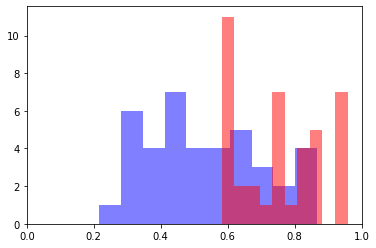

In [126]:
plt.hist(player_fits.VAC_288, color='blue', alpha=0.5)
plt.hist(player_fits.VAC_SO, color='red', alpha=0.5)
plt.xlim(0, 1)

(0.0, 1.0)

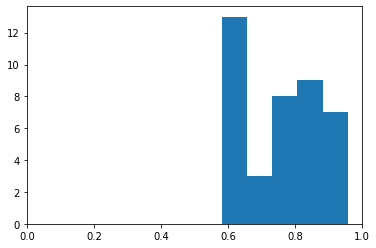

In [124]:
plt.hist(player_fits.VAC_SO, bins=5)
plt.xlim(0, 1)